# Nasdaq  Futures - Carga de Datos y Visualización

Este notebook carga los datos de NQ futures (2017-2025) y genera una visualización del precio.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import databento as db
from pathlib import Path
from typing import List, Optional
from pathlib import Path
Path('../output').mkdir(parents=True, exist_ok=True)

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

## 1. Configuración

In [2]:
# Ruta a los archivos de datos
DATA_DIR = Path("/Users/emiliosanchez/Desktop/pruebas_paco/test_TSI/data_markets copia/nasdaq")

# Años disponibles
YEARS = list(range(2017, 2026))  # 2017-2025

# Patrón de nombre de archivos
FILE_PATTERN = "NQ_futures_{year}_ohlcv-1m.dbn.zst"

## 2. Funciones de Carga y Limpieza

In [3]:
def load_dbn_file(filepath: Path) -> pd.DataFrame:
    """
    Carga un archivo DBN y devuelve DataFrame con OHLCV.
    """
    data = db.DBNStore.from_file(str(filepath))
    df = data.to_df()
    return df


def build_continuous_contract(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construye un contrato continuo usando el contrato más líquido por sesión.
    Excluye spreads (símbolos con '-').
    """
    # Filtrar solo contratos outright (sin spreads)
    df_futures = df[~df['symbol'].str.contains('-')].copy()
    
    # Determinar contrato dominante por día (mayor volumen)
    df_futures['date'] = df_futures.index.date
    daily_volume = df_futures.groupby(['date', 'symbol'])['volume'].sum().reset_index()
    dominant_contract = daily_volume.loc[daily_volume.groupby('date')['volume'].idxmax()]
    dominant_map = dominant_contract.set_index('date')['symbol'].to_dict()
    
    # Filtrar solo barras del contrato dominante
    df_futures['dominant'] = df_futures['date'].map(dominant_map)
    df_continuous = df_futures[df_futures['symbol'] == df_futures['dominant']].copy()
    
    return df_continuous[['open', 'high', 'low', 'close', 'volume']].sort_index()


def load_multiple_years(data_dir: Path, years: List[int], file_pattern: str) -> pd.DataFrame:
    """
    Carga múltiples años de datos y los concatena en un único DataFrame.
    """
    all_data = []
    
    for year in years:
        filepath = data_dir / file_pattern.format(year=year)
        
        if not filepath.exists():
            print(f"⚠️  Archivo no encontrado: {filepath.name}")
            continue
        
        print(f"📂 Cargando {filepath.name}...", end=" ")
        df_raw = load_dbn_file(filepath)
        df_continuous = build_continuous_contract(df_raw)
        print(f"{len(df_continuous):,} barras")
        
        all_data.append(df_continuous)
    
    if not all_data:
        raise ValueError("No se encontraron archivos de datos")
    
    # Concatenar todos los años
    df_full = pd.concat(all_data).sort_index()
    
    # Eliminar duplicados si los hay
    df_full = df_full[~df_full.index.duplicated(keep='first')]
    
    print(f"\n✅ Total: {len(df_full):,} barras de 1 minuto")
    print(f"   Desde: {df_full.index.min()}")
    print(f"   Hasta: {df_full.index.max()}")
    
    return df_full

## 3. Cargar Datos

In [4]:
# Cargar todos los años disponibles
df_1m = load_multiple_years(DATA_DIR, YEARS, FILE_PATTERN)

📂 Cargando NQ_futures_2017_ohlcv-1m.dbn.zst... 341,589 barras
📂 Cargando NQ_futures_2018_ohlcv-1m.dbn.zst... 347,872 barras
📂 Cargando NQ_futures_2019_ohlcv-1m.dbn.zst... 348,566 barras
📂 Cargando NQ_futures_2020_ohlcv-1m.dbn.zst... 347,608 barras
📂 Cargando NQ_futures_2021_ohlcv-1m.dbn.zst... 352,113 barras
📂 Cargando NQ_futures_2022_ohlcv-1m.dbn.zst... 354,113 barras
📂 Cargando NQ_futures_2023_ohlcv-1m.dbn.zst... 353,397 barras
📂 Cargando NQ_futures_2024_ohlcv-1m.dbn.zst... 353,694 barras
📂 Cargando NQ_futures_2025_ohlcv-1m.dbn.zst... 332,153 barras

✅ Total: 3,131,105 barras de 1 minuto
   Desde: 2017-01-02 23:00:00+00:00
   Hasta: 2025-12-09 23:59:00+00:00


In [5]:
# Vista previa de los datos
df_1m.head(10)

,open,high,low,close,volume
ts_event,,,,,
2017-01-02 23:00:00+00:00,4876.75,4890.25,4876.75,4888.00,488
2017-01-02 23:01:00+00:00,4888.00,4888.50,4887.00,4887.00,90
2017-01-02 23:02:00+00:00,4887.25,4888.00,4886.75,4887.75,70
2017-01-02 23:03:00+00:00,4887.75,4888.00,4887.50,4888.00,40
2017-01-02 23:04:00+00:00,4887.50,4890.00,4887.50,4890.00,89
2017-01-02 23:05:00+00:00,4889.75,4890.00,4887.50,4888.00,116
2017-01-02 23:06:00+00:00,4887.75,4889.25,4887.25,4888.00,128
2017-01-02 23:07:00+00:00,4887.50,4888.00,4887.00,4887.75,53
2017-01-02 23:08:00+00:00,4887.50,4887.75,4887.00,4887.75,62


In [6]:
# Estadísticas básicas
df_1m.describe()

,open,high,low,close,volume
count,3.131105e+06,3.131105e+06,3.131105e+06,3.131105e+06,3.131105e+06
mean,1.263766e+04,1.264017e+04,1.263511e+04,1.263766e+04,3.718220e+02
std,5.437737e+03,5.438626e+03,5.436812e+03,5.437737e+03,6.312429e+02
min,4.876750e+03,4.879000e+03,4.876750e+03,4.878500e+03,1.000000e+00
25%,7.498500e+03,7.500500e+03,7.496500e+03,7.498500e+03,4.200000e+01
50%,1.227300e+04,1.227650e+04,1.226925e+04,1.227300e+04,1.110000e+02
75%,1.587875e+04,1.588150e+04,1.587600e+04,1.587875e+04,4.280000e+02
max,2.639575e+04,2.639900e+04,2.639400e+04,2.639625e+04,2.036800e+04


## 4. Visualización del Precio

In [7]:
def resample_ohlcv(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Resamplea datos OHLCV a un timeframe mayor.
    
    Args:
        df: DataFrame con columnas OHLCV e índice datetime
        timeframe: String de pandas (ej: '5min', '1H', '1D')
    """
    return df.resample(timeframe).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()

In [8]:
# Resamplear a diario para visualización del histórico completo
df_daily = resample_ohlcv(df_1m, '1D')
print(f"Datos diarios: {len(df_daily)} sesiones")

Datos diarios: 2777 sesiones


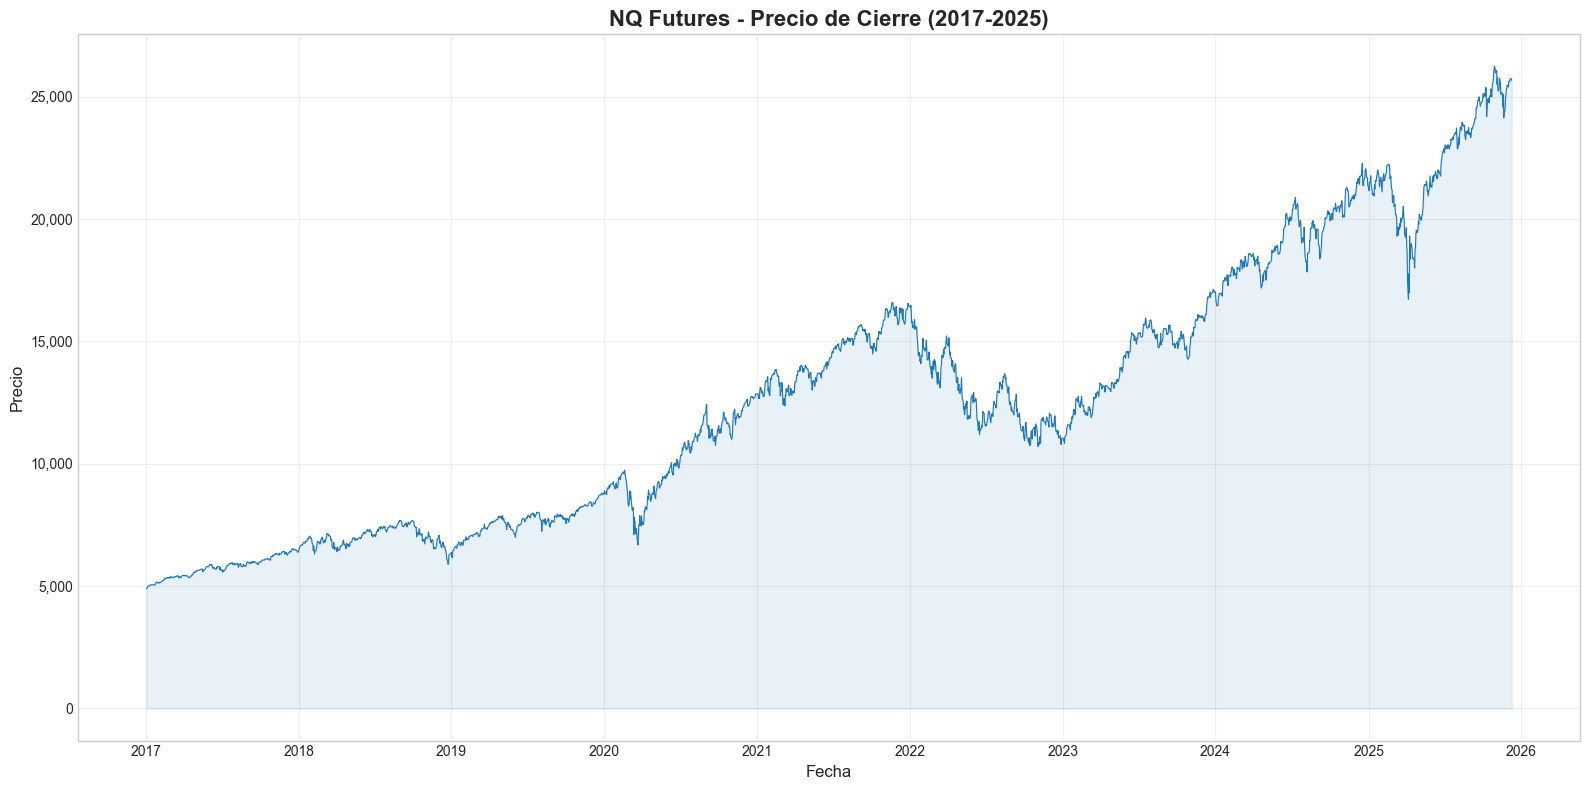

In [9]:
# Gráfico del precio histórico
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df_daily.index, df_daily['close'], color='#1f77b4', linewidth=0.8)
ax.fill_between(df_daily.index, df_daily['close'], alpha=0.1, color='#1f77b4')

ax.set_title('NQ Futures - Precio de Cierre (2017-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Precio', fontsize=12)
ax.grid(True, alpha=0.3)

# Formato del eje Y con separador de miles
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.savefig('../output/nq_price_history.png', dpi=150, bbox_inches='tight')
plt.show()

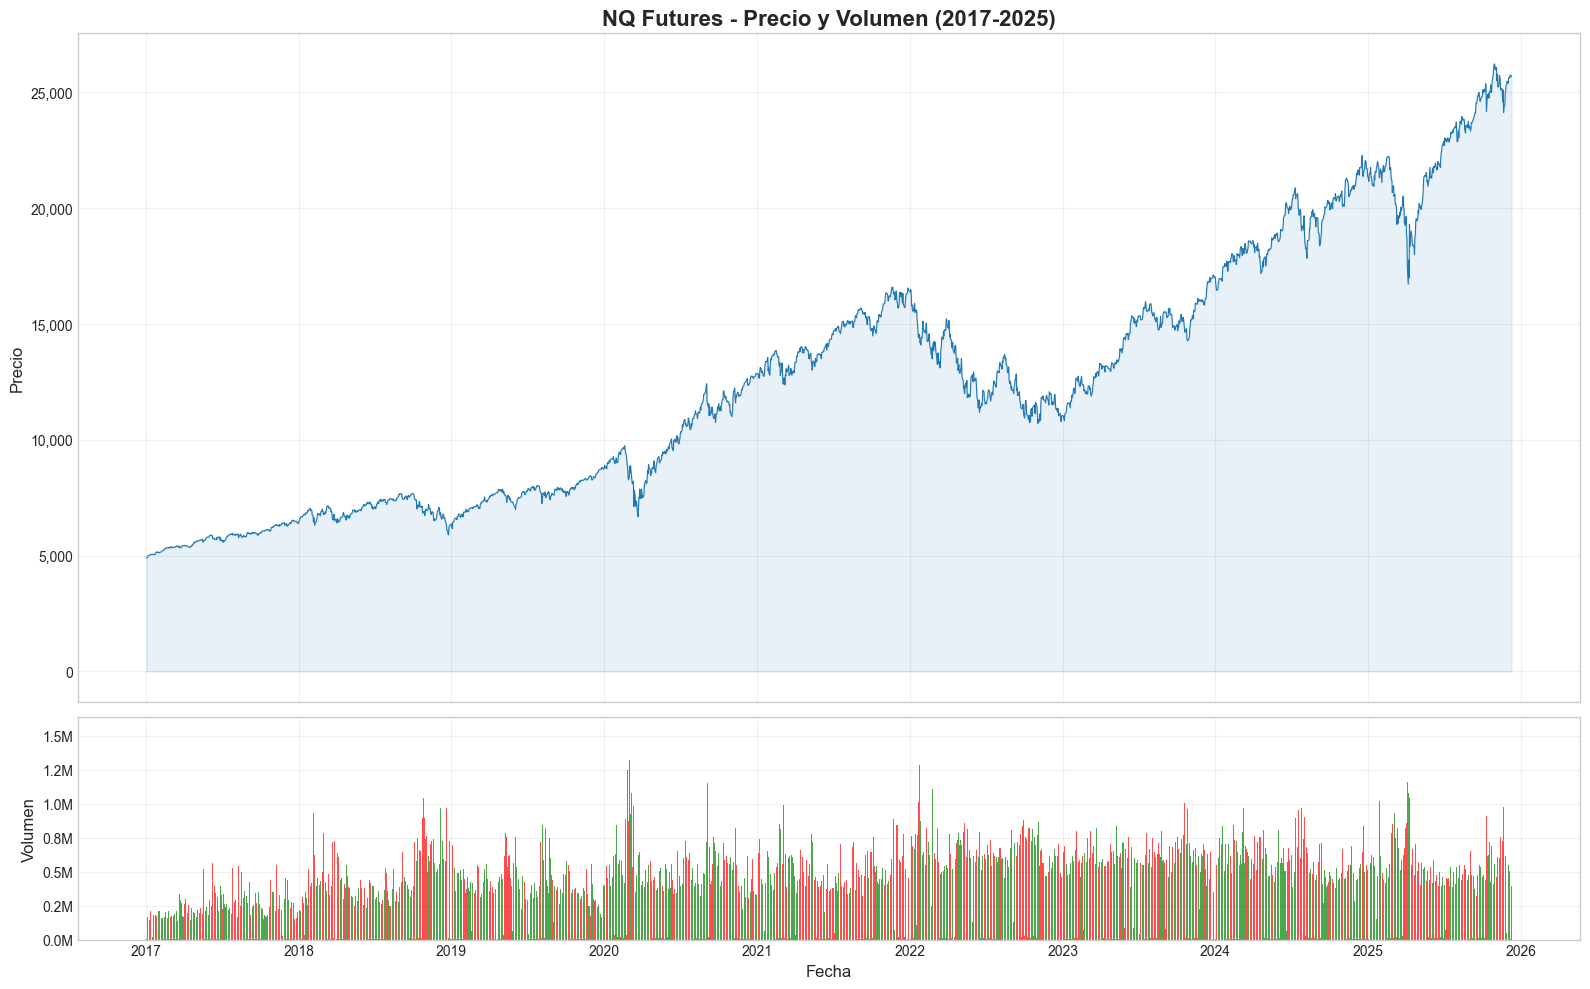

In [10]:
# Gráfico con volumen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), height_ratios=[3, 1], sharex=True)

# Precio
ax1.plot(df_daily.index, df_daily['close'], color='#1f77b4', linewidth=0.8)
ax1.fill_between(df_daily.index, df_daily['close'], alpha=0.1, color='#1f77b4')
ax1.set_ylabel('Precio', fontsize=12)
ax1.set_title('NQ Futures - Precio y Volumen (2017-2025)', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Volumen
colors = ['green' if df_daily['close'].iloc[i] >= df_daily['open'].iloc[i] else 'red' 
          for i in range(len(df_daily))]
ax2.bar(df_daily.index, df_daily['volume'], color=colors, alpha=0.7, width=1)
ax2.set_ylabel('Volumen', fontsize=12)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.savefig('../output/nq_price_volume_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Estadísticas por Año

In [11]:
# Estadísticas anuales
df_daily['year'] = df_daily.index.year
df_daily['return'] = df_daily['close'].pct_change()

yearly_stats = df_daily.groupby('year').agg({
    'open': 'first',
    'close': 'last',
    'high': 'max',
    'low': 'min',
    'volume': 'sum',
    'return': lambda x: (1 + x).prod() - 1  # Retorno anual compuesto
}).round(2)

yearly_stats.columns = ['Apertura', 'Cierre', 'Máximo', 'Mínimo', 'Volumen Total', 'Retorno %']
yearly_stats['Retorno %'] = (yearly_stats['Retorno %'] * 100).round(2)

yearly_stats

,Apertura,Cierre,Máximo,Mínimo,Volumen Total,Retorno %
year,,,,,,
2017,4876.75,6385.00,6545.75,4876.75,64251959,31.0
2018,6405.00,6342.75,7728.75,5820.50,117269892,-1.0
2019,6349.50,8735.00,8843.50,6136.50,108813209,38.0
2020,8776.75,12849.75,12918.25,6628.75,137020932,47.0
2021,12889.00,16437.75,16767.50,12207.25,131837413,28.0
2022,16356.00,11041.75,16564.00,10484.75,166421172,-33.0
2023,11122.50,17003.75,17165.25,10751.00,157171637,54.0
2024,17019.00,21391.25,22425.75,16334.25,148419176,26.0
2025,21269.00,25671.50,26399.00,16460.00,133008277,20.0


## REPRESENTACIÓN HEIKEN-ASHI

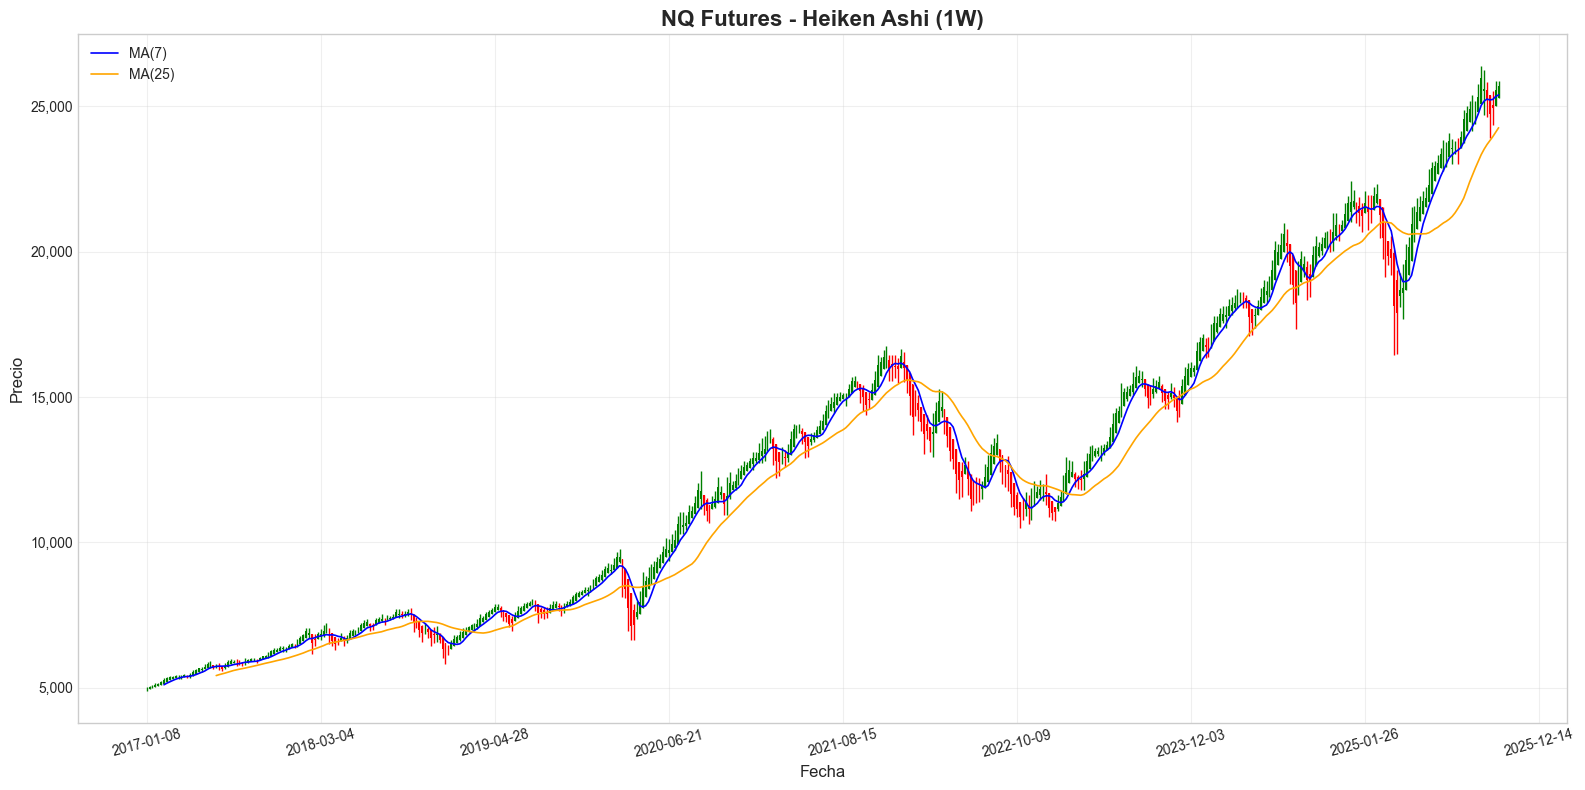

Timeframe: 1W
Total barras: 467
Desde: 2017-01-08 00:00:00+00:00
Hasta: 2025-12-14 00:00:00+00:00


In [12]:

from matplotlib.ticker import FuncFormatter, MaxNLocator
TIMEFRAME = '1W'  # <-- Cambia aquí el timeframe

# 1. Resamplear al timeframe elegido
df_tf = resample_ohlcv(df_1m, TIMEFRAME)

# Parámetros visuales
SHOW_MA = True
MA_1_PERIOD = 7
MA_2_PERIOD = 25

# 2. Calcular Heiken Ashi
def calculate_heiken_ashi(df):
    ha = pd.DataFrame(index=df.index)
    
    # HA Close (Vectorizado)
    ha['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    # HA Open (Recursivo - Optimizado con numpy para velocidad)
    # Nota: HA Open depende del valor previo, no es 100% vectorizable en pandas puro sin bucle,
    # pero este bucle sobre arrays de numpy es extremadamente rápido.
    open_arr = df['open'].to_numpy()
    close_arr = df['close'].to_numpy()
    ha_close_arr = ha['close'].to_numpy()
    
    ha_open_arr = np.zeros_like(open_arr)
    ha_open_arr[0] = (open_arr[0] + close_arr[0]) / 2
    
    for i in range(1, len(open_arr)):
        ha_open_arr[i] = (ha_open_arr[i-1] + ha_close_arr[i-1]) / 2
        
    ha['open'] = ha_open_arr
    
    # HA High y Low (Vectorizado)
    # El máximo entre el High original, el HA Open y el HA Close
    ha['high'] = np.maximum(df['high'], np.maximum(ha['open'], ha['close']))
    # El mínimo entre el Low original, el HA Open y el HA Close
    ha['low'] = np.minimum(df['low'], np.minimum(ha['open'], ha['close']))
    
    return ha

df_ha = calculate_heiken_ashi(df_tf)

# 3. Calcular Medias Móviles
if SHOW_MA:
    df_ha['MA_1'] = df_ha['close'].rolling(MA_1_PERIOD).mean()
    df_ha['MA_2'] = df_ha['close'].rolling(MA_2_PERIOD).mean()

# 4. Dibujar Gráfico (RENDERIZADO VECTORIZADO)
fig, ax = plt.subplots(figsize=(16, 8))

# Crear un índice numérico para el eje X
x_indices = np.arange(len(df_ha))

# Separar velas alcistas (verdes) y bajistas (rojas)
# up = Cierre >= Apertura
up = df_ha[df_ha['close'] >= df_ha['open']]
up_idx = np.where(df_ha['close'] >= df_ha['open'])[0]

# down = Cierre < Apertura
down = df_ha[df_ha['close'] < df_ha['open']]
down_idx = np.where(df_ha['close'] < df_ha['open'])[0]

# Ancho de las velas
width = 0.6
width2 = 0.05  # Ancho de las mechas

# DIBUJAR VELAS ALCISTAS (VERDES)
# Mechas
ax.vlines(x_indices[up_idx], up['low'], up['high'], color='green', linewidth=1)
# Cuerpos (usamos bar plot para velocidad)
ax.bar(x_indices[up_idx], up['close'] - up['open'], bottom=up['open'], color='green', width=width)

# DIBUJAR VELAS BAJISTAS (ROJAS)
# Mechas
ax.vlines(x_indices[down_idx], down['low'], down['high'], color='red', linewidth=1)
# Cuerpos
ax.bar(x_indices[down_idx], down['close'] - down['open'], bottom=down['open'], color='red', width=width)

# DIBUJAR MEDIAS MÓVILES
if SHOW_MA:
    ax.plot(x_indices, df_ha['MA_1'], color='blue', linewidth=1.2, label=f'MA({MA_1_PERIOD})')
    ax.plot(x_indices, df_ha['MA_2'], color='orange', linewidth=1.2, label=f'MA({MA_2_PERIOD})')
    ax.legend(loc='upper left')

# 5. Formatear Ejes
ax.set_title(f'NQ Futures - Heiken Ashi ({TIMEFRAME})', fontsize=16, fontweight='bold')
ax.set_ylabel('Precio', fontsize=12)
ax.set_xlabel('Fecha', fontsize=12)
ax.grid(True, alpha=0.3)

# Formatear Eje Y (Precio con separador de miles)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Formatear Eje X (Mostrar fechas en lugar de índices)
# Limitamos el número de etiquetas para que no se amontonen
def format_date(x, pos=None):
    thisind = np.clip(int(x + 0.5), 0, len(df_ha) - 1)
    return df_ha.index[thisind].strftime('%Y-%m-%d')

ax.xaxis.set_major_locator(MaxNLocator(10)) # Máximo 10 fechas en el eje X
ax.xaxis.set_major_formatter(FuncFormatter(format_date))
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

print(f"Timeframe: {TIMEFRAME}")
print(f"Total barras: {len(df_ha):,}")
print(f"Desde: {df_ha.index.min()}")
print(f"Hasta: {df_ha.index.max()}")

# Cálculo TSI

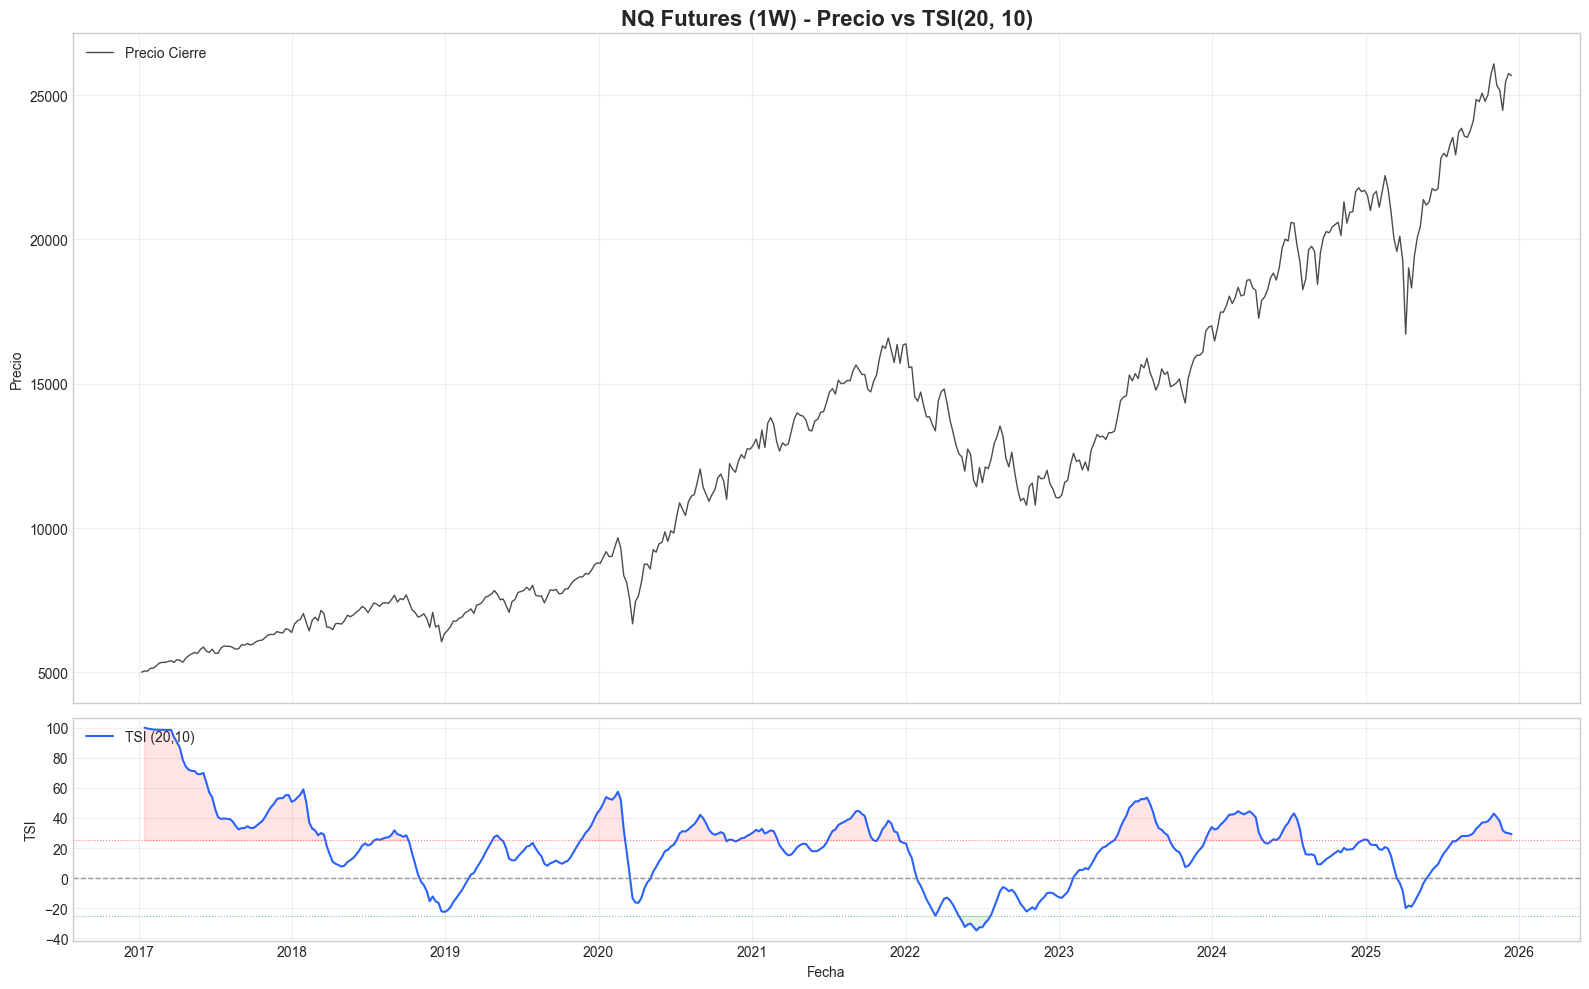

Últimos valores del TSI (20, 10):
                              close        TSI
ts_event                                      
2025-11-16 00:00:00+00:00  25170.75  37.760950
2025-11-23 00:00:00+00:00  24471.50  31.738157
2025-11-30 00:00:00+00:00  25466.25  30.172311
2025-12-07 00:00:00+00:00  25746.50  29.838941
2025-12-14 00:00:00+00:00  25671.50  29.207652


In [13]:
# =============================================================================
# CÁLCULO Y VISUALIZACIÓN DEL TSI (True Strength Index)
# =============================================================================

# Parámetros del TSI configurables
TSI_R = 20  # Período largo (suavizado del momento)
TSI_S = 10  # Período corto (suavizado del suavizado)

def calculate_tsi(df, r=25, s=13):
    """
    Calcula el True Strength Index (TSI).
    Formula:
        M = Close - Close_prev
        TSI = 100 * (EMA(EMA(M, r), s) / EMA(EMA(|M|, r), s))
    """
    # 1. Calcular el cambio de precio (Momentum)
    diff = df['close'].diff()
    
    # 2. Calcular el primer suavizado (EMA r)
    # Usamos adjust=False para replicar el estándar técnico clásico
    ema1_diff = diff.ewm(span=r, adjust=False).mean()
    ema1_abs_diff = diff.abs().ewm(span=r, adjust=False).mean()
    
    # 3. Calcular el segundo suavizado (EMA s) del resultado anterior
    ema2_diff = ema1_diff.ewm(span=s, adjust=False).mean()
    ema2_abs_diff = ema1_abs_diff.ewm(span=s, adjust=False).mean()
    
    # 4. Calcular TSI
    tsi = 100 * (ema2_diff / ema2_abs_diff)
    
    return tsi

# Calcular TSI sobre el dataframe resampleado (df_tf)
# Asegúrate de haber ejecutado la celda anterior para tener df_tf definido
df_tf['TSI'] = calculate_tsi(df_tf, r=TSI_R, s=TSI_S)

# =============================================================================
# GRAFICAR PRECIO Y TSI
# =============================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# --- Subplot 1: Precio (Velas Heiken Ashi o Cierre) ---
# Usamos el cierre simple para mayor claridad junto al oscilador, 
# pero puedes usar las velas HA si prefieres.
ax1.plot(df_tf.index, df_tf['close'], label='Precio Cierre', color='black', linewidth=1, alpha=0.7)
ax1.set_title(f'NQ Futures ({TIMEFRAME}) - Precio vs TSI({TSI_R}, {TSI_S})', fontsize=16, fontweight='bold')
ax1.set_ylabel('Precio')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# --- Subplot 2: TSI ---
tsi_color = '#2962FF' # Azul vibrante
ax2.plot(df_tf.index, df_tf['TSI'], label=f'TSI ({TSI_R},{TSI_S})', color=tsi_color, linewidth=1.5)

# Línea cero (Centro)
ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.8)

# Niveles de referencia (Sobrecompra/Sobreventa típicos)
ax2.axhline(25, color='red', linestyle=':', linewidth=0.8, alpha=0.5)
ax2.axhline(-25, color='green', linestyle=':', linewidth=0.8, alpha=0.5)

# Relleno para destacar zonas extremas (Opcional)
ax2.fill_between(df_tf.index, 25, df_tf['TSI'], where=(df_tf['TSI'] >= 25), 
                 color='red', alpha=0.1, interpolate=True)
ax2.fill_between(df_tf.index, -25, df_tf['TSI'], where=(df_tf['TSI'] <= -25), 
                 color='green', alpha=0.1, interpolate=True)

ax2.set_ylabel('TSI')
ax2.set_xlabel('Fecha')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')

# Formato de fechas en eje X (mejora visual)
import matplotlib.dates as mdates
# Si hay muchos datos, mostramos solo años/meses principales
if len(df_tf) > 200:
    ax2.xaxis.set_major_locator(mdates.YearLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

plt.tight_layout()
plt.show()

# Mostrar últimos valores
print(f"Últimos valores del TSI ({TSI_R}, {TSI_S}):")
print(df_tf[['close', 'TSI']].tail(5))

# Backtesting con TSI
 compra cuando  el TSI cruza el 0 sentido ascendente
 vende cuando inflexiona la media de 7 sesiones.

Iniciando Backtest (Spread: 2.0 pts | Lotes: 1)...

✅ 1min  | Pts: -136,707.50 | Ops: 68899
✅ 2min  | Pts: -64,629.25 | Ops: 34423
✅ 5min  | Pts: -16,877.50 | Ops: 13455
✅ 15min | Pts: -1,925.00 | Ops: 4330
✅ 1h    | Pts: 7,323.00 | Ops: 1039
✅ 4h    | Pts: 7,205.75 | Ops: 279
✅ 1D    | Pts: 2,155.00 | Ops: 46
✅ 1W    | Pts: 8,686.25 | Ops: 5

COMPARATIVA POR BENEFICIO ACUMULADO (1 Título)
Timeframe Beneficio (Puntos) Retorno %  Operaciones Win Rate
       1W           8,686.25    96.72%            5  100.00%
       1h           7,323.00    44.61%         1039   37.92%
       4h           7,205.75    64.65%          279   45.16%
       1D           2,155.00    15.32%           46   39.13%
    15min          -1,925.00   -25.91%         4330   32.52%
     5min         -16,877.50   -83.50%        13455   29.99%
     2min         -64,629.25   -99.82%        34423   26.16%
     1min        -136,707.50  -100.00%        68899   23.32%


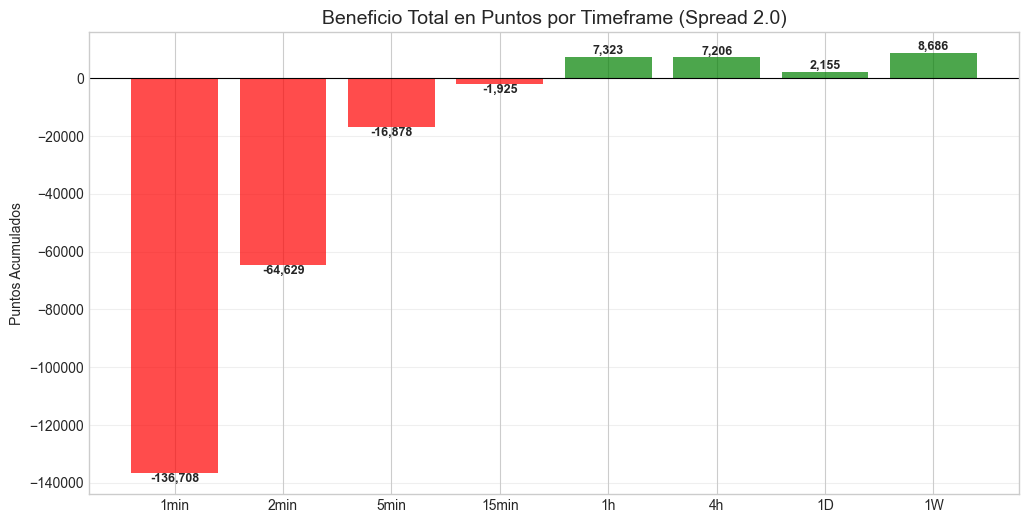

In [14]:


# =============================================================================
# BACKTEST MULTI-TIMEFRAME: TSI + SALIDA MA(7) + BENEFICIO EN PUNTOS
# =============================================================================

# Configuración
TIMEFRAMES = ['1min', '2min', '5min', '15min', '1h', '4h', '1D', '1W']
SPREAD = 2.0  # Coste en puntos por operación (1 título)

all_results = []

# Funciones auxiliares
def resample_ohlcv(df, timeframe):
    if timeframe == '1min': return df
    return df.resample(timeframe).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()

def calculate_tsi(df, r=20, s=10):
    diff = df['close'].diff()
    ema1_diff = diff.ewm(span=r, adjust=False).mean()
    ema1_abs_diff = diff.abs().ewm(span=r, adjust=False).mean()
    ema2_diff = ema1_diff.ewm(span=s, adjust=False).mean()
    ema2_abs_diff = ema1_abs_diff.ewm(span=s, adjust=False).mean()
    # Evitar división por cero
    tsi = 100 * (ema2_diff / ema2_abs_diff.replace(0, np.nan))
    return tsi.fillna(0)

print(f"Iniciando Backtest (Spread: {SPREAD} pts | Lotes: 1)...\n")

# --- BUCLE PRINCIPAL ---
for tf in TIMEFRAMES:
    try:
        # 1. Resamplear (Usamos df_1m, asegúrate que esté cargado)
        df_tf = resample_ohlcv(df_1m, tf)
        
        if len(df_tf) < 50: 
            print(f"⚠️ {tf}: Insuficientes datos")
            continue

        # 2. Indicadores
        df_tf['TSI'] = calculate_tsi(df_tf, r=20, s=10)
        df_tf['MA_7'] = df_tf['close'].rolling(window=7).mean()
        
        # 3. Señales
        df_tf['TSI_prev'] = df_tf['TSI'].shift(1)
        df_tf['MA_7_prev'] = df_tf['MA_7'].shift(1)
        df_tf['MA_7_prev_2'] = df_tf['MA_7'].shift(2)
        
        # Compra: TSI cruza 0 arriba
        signal_buy = (df_tf['TSI'] > 0) & (df_tf['TSI_prev'] <= 0)
        
        # Venta: MA(7) inflexiona a la baja
        signal_sell = (df_tf['MA_7'] < df_tf['MA_7_prev']) & (df_tf['MA_7_prev'] >= df_tf['MA_7_prev_2'])
        
        # 4. Simulación de Trades
        trades_points = []
        trades_pct = []
        
        in_position = False
        entry_price = 0.0
        
        # Convertimos a arrays para iterar rápido
        buy_arr = signal_buy.values
        sell_arr = signal_sell.values
        close_arr = df_tf['close'].values
        
        for i in range(len(df_tf)):
            if not in_position:
                if buy_arr[i]:
                    in_position = True
                    entry_price = close_arr[i]
            else:
                if sell_arr[i]:
                    in_position = False
                    exit_price = close_arr[i]
                    
                    # --- CÁLCULO DE BENEFICIO (1 Título) ---
                    # Puntos = Salida - Entrada - Spread
                    pnl_pts = exit_price - entry_price - SPREAD
                    trades_points.append(pnl_pts)
                    
                    # Retorno %
                    pnl_pct = pnl_pts / entry_price
                    trades_pct.append(pnl_pct)
        
        # 5. Métricas y Guardado
        if len(trades_points) > 0:
            trades_np_points = np.array(trades_points)
            
            # Beneficio Total Acumulado (Suma de puntos)
            total_profit_points = np.sum(trades_np_points)
            
            # Retorno Total (% Compuesto)
            equity_curve = (1 + np.array(trades_pct)).cumprod()
            total_return_pct = equity_curve[-1] - 1
            
            win_rate = np.sum(trades_np_points > 0) / len(trades_np_points)
            
            all_results.append({
                'Timeframe': tf,
                'Beneficio (Puntos)': total_profit_points,  # <--- NUEVO
                'Retorno %': total_return_pct,
                'Operaciones': len(trades_points),
                'Win Rate': win_rate
            })
            print(f"✅ {tf:<5} | Pts: {total_profit_points:,.2f} | Ops: {len(trades_points)}")
        else:
            print(f"⚠️ {tf:<5} | Sin operaciones")
            
    except Exception as e:
        print(f"❌ Error en {tf}: {str(e)}")

# =============================================================================
# RESULTADOS
# =============================================================================
if all_results:
    df_res = pd.DataFrame(all_results)
    
    # Formato para la tabla
    formatters = {
        'Beneficio (Puntos)': '{:,.2f}'.format,
        'Retorno %': '{:.2%}'.format,
        'Win Rate': '{:.2%}'.format
    }
    
    print("\n" + "="*60)
    print("COMPARATIVA POR BENEFICIO ACUMULADO (1 Título)")
    print("="*60)
    # Ordenar por Beneficio en Puntos
    print(df_res.sort_values(by='Beneficio (Puntos)', ascending=False)
                .to_string(index=False, formatters=formatters))

    # =============================================================================
    # GRÁFICO DE BARRAS
    # =============================================================================
    plt.figure(figsize=(12, 6))
    colors = ['green' if x >= 0 else 'red' for x in df_res['Beneficio (Puntos)']]
    bars = plt.bar(df_res['Timeframe'], df_res['Beneficio (Puntos)'], color=colors, alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:,.0f}',
                 ha='center', va='bottom' if height >= 0 else 'top', fontsize=9, fontweight='bold')

    plt.title(f'Beneficio Total en Puntos por Timeframe (Spread {SPREAD})', fontsize=14)
    plt.ylabel('Puntos Acumulados')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print("No se generaron resultados.")

ESTRATEGIA CORTOS: EMA(70) + TSI + PARABOLIC SAR
Entrada corto: Precio cruza EMA(70) hacia abajo + EMA descendente + TSI < -10
Salida: Precio toca Parabolic SAR (start=0.02, inc=0.02, max=0.2)
Horario: 8:00 - 21:45 GMT
Spread: 2.0 pts

✅ 2min   | Pts:  77,969.33 | Ops:  4746 | WR: 85.2% | PF: 69.09
✅ 5min   | Pts:  57,017.25 | Ops:  1948 | WR: 91.3% | PF: 128.43
✅ 10min  | Pts:  46,603.22 | Ops:   994 | WR: 96.4% | PF: 386.88
✅ 15min  | Pts:  34,259.08 | Ops:   677 | WR: 97.8% | PF: 341.89
✅ 30min  | Pts:  25,211.25 | Ops:   339 | WR: 98.5% | PF: 1201.54
✅ 1h     | Pts:  19,832.07 | Ops:   174 | WR: 99.4% | PF: 2559.98
✅ 4h     | Pts:  11,203.80 | Ops:    58 | WR: 98.3% | PF: 182.44
⚠️ 1D: Insuficientes datos (0 barras)

RESULTADOS ESTRATEGIA CORTOS - EMA(70) + TSI + PARABOLIC SAR

📊 TABLA COMPARATIVA POR TIMEFRAME:

Timeframe Beneficio (Pts)  Retorno % Operaciones Win Rate Profit Factor Max DD (Pts)    Avg Win   Avg Loss
     2min       77,969.33  37485.57%        4746    85.2%       

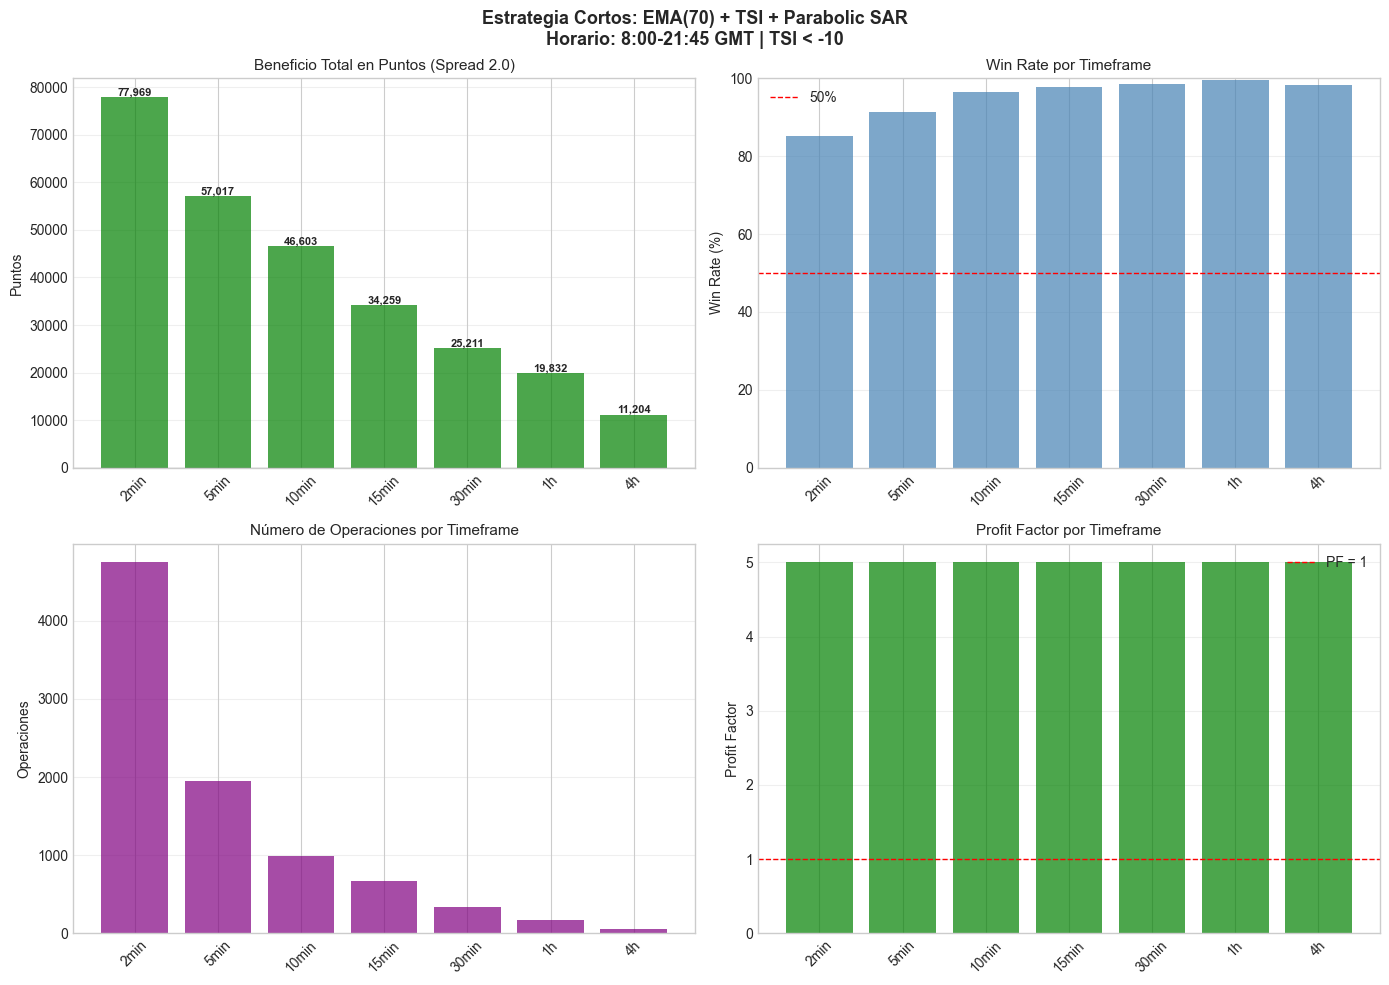


📈 RESUMEN:

🏆 Mejor timeframe: 2min
   Beneficio: 77,969.33 pts | Win Rate: 85.2% | Profit Factor: 69.09

⚠️  Peor timeframe: 4h
   Beneficio: 11,203.80 pts | Win Rate: 98.3% | Profit Factor: 182.44

📊 Total operaciones (todos TF): 8,936
📊 Win Rate promedio: 95.3%


In [15]:
# =============================================================================
# BACKTEST ESTRATEGIA CORTOS: EMA(70) + TSI + PARABOLIC SAR
# =============================================================================
# Entrada en corto: Precio cruza EMA(70) desde arriba hacia abajo, 
#                   con EMA descendente y TSI < -10
# Salida: Precio toca el Parabolic SAR
# Horario: 8:00 a 21:45 GMT
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración
TIMEFRAMES = ['2min', '5min', '10min', '15min', '30min', '1h', '4h', '1D']
SPREAD = 2.0  # Coste en puntos por operación

# Parámetros de indicadores
EMA_PERIOD = 70
TSI_R = 20  # Período largo TSI
TSI_S = 10  # Período corto TSI
TSI_THRESHOLD = -10  # Umbral para entrada

# Parabolic SAR
PSAR_START = 0.02
PSAR_INCREMENT = 0.02
PSAR_MAXIMUM = 0.2

# Horario de trading (GMT)
TRADING_START = 8   # 8:00
TRADING_END = 21    # 21:45 (se filtra <= 21:45)

all_results_short = []

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

def resample_ohlcv(df, timeframe):
    """Resamplea datos OHLCV al timeframe especificado."""
    if timeframe == '1min': 
        return df.copy()
    return df.resample(timeframe).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()


def calculate_tsi(df, r=20, s=10):
    """Calcula el True Strength Index."""
    diff = df['close'].diff()
    ema1_diff = diff.ewm(span=r, adjust=False).mean()
    ema1_abs_diff = diff.abs().ewm(span=r, adjust=False).mean()
    ema2_diff = ema1_diff.ewm(span=s, adjust=False).mean()
    ema2_abs_diff = ema1_abs_diff.ewm(span=s, adjust=False).mean()
    tsi = 100 * (ema2_diff / ema2_abs_diff.replace(0, np.nan))
    return tsi.fillna(0)


def calculate_parabolic_sar(df, start=0.02, increment=0.02, maximum=0.2):
    """
    Calcula el Parabolic SAR.
    Devuelve una Serie con los valores del SAR.
    """
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    n = len(df)
    
    psar = np.zeros(n)
    af = start
    ep = 0
    trend = 1  # 1 = alcista, -1 = bajista
    
    # Inicialización
    psar[0] = low[0] if trend == 1 else high[0]
    ep = high[0] if trend == 1 else low[0]
    
    for i in range(1, n):
        # Calcular SAR provisional
        psar[i] = psar[i-1] + af * (ep - psar[i-1])
        
        if trend == 1:  # Tendencia alcista
            # El SAR no puede estar por encima de los mínimos anteriores
            psar[i] = min(psar[i], low[i-1])
            if i > 1:
                psar[i] = min(psar[i], low[i-2])
            
            # Verificar reversión
            if low[i] < psar[i]:
                trend = -1
                psar[i] = ep
                ep = low[i]
                af = start
            else:
                # Actualizar EP y AF
                if high[i] > ep:
                    ep = high[i]
                    af = min(af + increment, maximum)
        else:  # Tendencia bajista
            # El SAR no puede estar por debajo de los máximos anteriores
            psar[i] = max(psar[i], high[i-1])
            if i > 1:
                psar[i] = max(psar[i], high[i-2])
            
            # Verificar reversión
            if high[i] > psar[i]:
                trend = 1
                psar[i] = ep
                ep = high[i]
                af = start
            else:
                # Actualizar EP y AF
                if low[i] < ep:
                    ep = low[i]
                    af = min(af + increment, maximum)
    
    return pd.Series(psar, index=df.index)


def filter_trading_hours(df):
    """
    Filtra el DataFrame para mantener solo el horario de trading 8:00-21:45 GMT.
    """
    df_filtered = df.copy()
    
    # Asegurar que el índice está en UTC/GMT
    if df_filtered.index.tz is not None and str(df_filtered.index.tz) != 'UTC':
        df_filtered.index = df_filtered.index.tz_convert('UTC')
    
    # Filtrar por hora
    hour = df_filtered.index.hour
    minute = df_filtered.index.minute
    
    # 8:00 <= hora < 21:45
    mask = (
        ((hour >= TRADING_START) & (hour < TRADING_END)) |
        ((hour == TRADING_END) & (minute <= 45))
    )
    
    return df_filtered[mask]


print("="*70)
print("ESTRATEGIA CORTOS: EMA(70) + TSI + PARABOLIC SAR")
print("="*70)
print(f"Entrada corto: Precio cruza EMA(70) hacia abajo + EMA descendente + TSI < {TSI_THRESHOLD}")
print(f"Salida: Precio toca Parabolic SAR (start={PSAR_START}, inc={PSAR_INCREMENT}, max={PSAR_MAXIMUM})")
print(f"Horario: {TRADING_START}:00 - {TRADING_END}:45 GMT")
print(f"Spread: {SPREAD} pts")
print("="*70 + "\n")

# =============================================================================
# BUCLE PRINCIPAL
# =============================================================================

for tf in TIMEFRAMES:
    try:
        # 1. Resamplear
        df_tf = resample_ohlcv(df_1m, tf)
        
        # 2. Filtrar horario de trading
        df_tf = filter_trading_hours(df_tf)
        
        if len(df_tf) < EMA_PERIOD + 10:
            print(f"⚠️ {tf}: Insuficientes datos ({len(df_tf)} barras)")
            continue
        
        # 3. Calcular indicadores
        df_tf['EMA_70'] = df_tf['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
        df_tf['TSI'] = calculate_tsi(df_tf, r=TSI_R, s=TSI_S)
        df_tf['PSAR'] = calculate_parabolic_sar(df_tf, PSAR_START, PSAR_INCREMENT, PSAR_MAXIMUM)
        
        # 4. Calcular condiciones de señal
        # EMA descendente: EMA actual < EMA anterior
        df_tf['EMA_prev'] = df_tf['EMA_70'].shift(1)
        df_tf['EMA_descendente'] = df_tf['EMA_70'] < df_tf['EMA_prev']
        
        # Precio cruza EMA desde arriba hacia abajo
        df_tf['close_prev'] = df_tf['close'].shift(1)
        df_tf['cruce_bajista'] = (df_tf['close_prev'] > df_tf['EMA_prev']) & (df_tf['close'] < df_tf['EMA_70'])
        
        # Señal de entrada en corto
        signal_short = (
            df_tf['cruce_bajista'] &           # Precio cruza EMA hacia abajo
            df_tf['EMA_descendente'] &          # EMA tiene pendiente descendente
            (df_tf['TSI'] < TSI_THRESHOLD)      # TSI < -10
        )
        
        # 5. Simulación de Trades
        trades_points = []
        trades_pct = []
        trades_details = []
        
        in_position = False
        entry_price = 0.0
        entry_date = None
        
        short_arr = signal_short.values
        close_arr = df_tf['close'].values
        high_arr = df_tf['high'].values
        psar_arr = df_tf['PSAR'].values
        dates_arr = df_tf.index
        
        for i in range(len(df_tf)):
            if not in_position:
                # Buscar entrada en corto
                if short_arr[i]:
                    in_position = True
                    entry_price = close_arr[i]
                    entry_date = dates_arr[i]
            else:
                # Estamos en posición corta, buscar salida
                # Salida cuando el HIGH toca o supera el PSAR (precio sube hasta SAR)
                if high_arr[i] >= psar_arr[i]:
                    in_position = False
                    # Salimos al precio del PSAR (o al high si es menor)
                    exit_price = min(psar_arr[i], high_arr[i])
                    
                    # Beneficio en corto: Entrada - Salida - Spread
                    pnl_pts = entry_price - exit_price - SPREAD
                    trades_points.append(pnl_pts)
                    
                    # Retorno %
                    pnl_pct = pnl_pts / entry_price
                    trades_pct.append(pnl_pct)
                    
                    trades_details.append({
                        'entry_date': entry_date,
                        'exit_date': dates_arr[i],
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'pnl_pts': pnl_pts
                    })
        
        # 6. Métricas
        if len(trades_points) > 0:
            trades_np = np.array(trades_points)
            
            total_profit_points = np.sum(trades_np)
            
            # Equity curve
            equity_curve = (1 + np.array(trades_pct)).cumprod()
            total_return_pct = equity_curve[-1] - 1
            
            win_rate = np.sum(trades_np > 0) / len(trades_np)
            
            # Profit Factor
            gross_profit = np.sum(trades_np[trades_np > 0])
            gross_loss = abs(np.sum(trades_np[trades_np < 0]))
            profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
            
            # Max Drawdown
            equity = np.cumsum(trades_np)
            running_max = np.maximum.accumulate(equity)
            drawdown = running_max - equity
            max_drawdown = np.max(drawdown)
            
            # Average trade
            avg_win = np.mean(trades_np[trades_np > 0]) if np.any(trades_np > 0) else 0
            avg_loss = np.mean(trades_np[trades_np < 0]) if np.any(trades_np < 0) else 0
            
            all_results_short.append({
                'Timeframe': tf,
                'Beneficio (Pts)': total_profit_points,
                'Retorno %': total_return_pct,
                'Operaciones': len(trades_points),
                'Win Rate': win_rate,
                'Profit Factor': profit_factor,
                'Max DD (Pts)': max_drawdown,
                'Avg Win': avg_win,
                'Avg Loss': avg_loss
            })
            
            print(f"✅ {tf:<6} | Pts: {total_profit_points:>10,.2f} | Ops: {len(trades_points):>5} | "
                  f"WR: {win_rate:.1%} | PF: {profit_factor:.2f}")
        else:
            print(f"⚠️ {tf:<6} | Sin operaciones cerradas")
            
    except Exception as e:
        print(f"❌ Error en {tf}: {str(e)}")
        import traceback
        traceback.print_exc()

# =============================================================================
# RESULTADOS
# =============================================================================

if all_results_short:
    print("\n" + "="*80)
    print("RESULTADOS ESTRATEGIA CORTOS - EMA(70) + TSI + PARABOLIC SAR")
    print("="*80)
    
    df_res_short = pd.DataFrame(all_results_short)
    
    # Ordenar por beneficio
    df_res_sorted = df_res_short.sort_values(by='Beneficio (Pts)', ascending=False)
    
    # Mostrar tabla formateada
    print("\n📊 TABLA COMPARATIVA POR TIMEFRAME:\n")
    
    formatters = {
        'Beneficio (Pts)': '{:>12,.2f}'.format,
        'Retorno %': '{:>10.2%}'.format,
        'Operaciones': '{:>6}'.format,
        'Win Rate': '{:>8.1%}'.format,
        'Profit Factor': '{:>8.2f}'.format,
        'Max DD (Pts)': '{:>10,.2f}'.format,
        'Avg Win': '{:>10,.2f}'.format,
        'Avg Loss': '{:>10,.2f}'.format
    }
    
    print(df_res_sorted.to_string(index=False, formatters=formatters))
    
    # =============================================================================
    # GRÁFICO DE BARRAS
    # =============================================================================
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Gráfico 1: Beneficio en puntos
    ax1 = axes[0, 0]
    colors = ['green' if x >= 0 else 'red' for x in df_res_short['Beneficio (Pts)']]
    bars = ax1.bar(df_res_short['Timeframe'], df_res_short['Beneficio (Pts)'], color=colors, alpha=0.7)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:,.0f}', ha='center', 
                 va='bottom' if height >= 0 else 'top', fontsize=8, fontweight='bold')
    ax1.set_title(f'Beneficio Total en Puntos (Spread {SPREAD})', fontsize=11)
    ax1.set_ylabel('Puntos')
    ax1.axhline(0, color='black', linewidth=0.8)
    ax1.grid(axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Win Rate
    ax2 = axes[0, 1]
    ax2.bar(df_res_short['Timeframe'], df_res_short['Win Rate'] * 100, color='steelblue', alpha=0.7)
    ax2.axhline(50, color='red', linestyle='--', linewidth=1, label='50%')
    ax2.set_title('Win Rate por Timeframe', fontsize=11)
    ax2.set_ylabel('Win Rate (%)')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    
    # Gráfico 3: Número de operaciones
    ax3 = axes[1, 0]
    ax3.bar(df_res_short['Timeframe'], df_res_short['Operaciones'], color='purple', alpha=0.7)
    ax3.set_title('Número de Operaciones por Timeframe', fontsize=11)
    ax3.set_ylabel('Operaciones')
    ax3.grid(axis='y', alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Gráfico 4: Profit Factor
    ax4 = axes[1, 1]
    pf_colors = ['green' if x >= 1 else 'red' for x in df_res_short['Profit Factor']]
    # Limitar profit factor para visualización
    pf_display = df_res_short['Profit Factor'].clip(upper=5)
    ax4.bar(df_res_short['Timeframe'], pf_display, color=pf_colors, alpha=0.7)
    ax4.axhline(1, color='red', linestyle='--', linewidth=1, label='PF = 1')
    ax4.set_title('Profit Factor por Timeframe', fontsize=11)
    ax4.set_ylabel('Profit Factor')
    ax4.grid(axis='y', alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend()
    
    plt.suptitle('Estrategia Cortos: EMA(70) + TSI + Parabolic SAR\n'
                 f'Horario: 8:00-21:45 GMT | TSI < {TSI_THRESHOLD}', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../output/estrategia_cortos_ema70_tsi_psar.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Resumen final
    print("\n" + "="*80)
    print("📈 RESUMEN:")
    print("="*80)
    best_tf = df_res_sorted.iloc[0]
    worst_tf = df_res_sorted.iloc[-1]
    
    print(f"\n🏆 Mejor timeframe: {best_tf['Timeframe']}")
    print(f"   Beneficio: {best_tf['Beneficio (Pts)']:,.2f} pts | "
          f"Win Rate: {best_tf['Win Rate']:.1%} | "
          f"Profit Factor: {best_tf['Profit Factor']:.2f}")
    
    print(f"\n⚠️  Peor timeframe: {worst_tf['Timeframe']}")
    print(f"   Beneficio: {worst_tf['Beneficio (Pts)']:,.2f} pts | "
          f"Win Rate: {worst_tf['Win Rate']:.1%} | "
          f"Profit Factor: {worst_tf['Profit Factor']:.2f}")
    
    total_ops = df_res_short['Operaciones'].sum()
    avg_win_rate = df_res_short['Win Rate'].mean()
    print(f"\n📊 Total operaciones (todos TF): {total_ops:,}")
    print(f"📊 Win Rate promedio: {avg_win_rate:.1%}")
    
else:
    print("\n❌ No se generaron resultados.")

ESTRATEGIA CORTOS 5MIN: EMA(70) + TSI + PARABOLIC SAR
Datos 5min filtrados: 359,763 barras
Desde: 2017-01-03 08:00:00+00:00
Hasta: 2025-12-09 21:45:00+00:00

ESTADÍSTICAS DE LA ESTRATEGIA

📊 Operaciones totales: 1948
   ├─ Ganadoras: 1779 (91.3%)
   └─ Perdedoras: 169 (8.7%)

💰 Beneficio total: 57,017.25 pts
   ├─ Beneficio bruto: 57,464.69 pts
   └─ Pérdida bruta: -447.44 pts

📈 Profit Factor: 128.43
📉 Max Drawdown: 33.75 pts

⏱️  Duración media: 0 days 01:37:55.564681724
   ├─ Ganancia media: 32.30 pts
   └─ Pérdida media: -2.65 pts

GENERANDO GRÁFICOS...


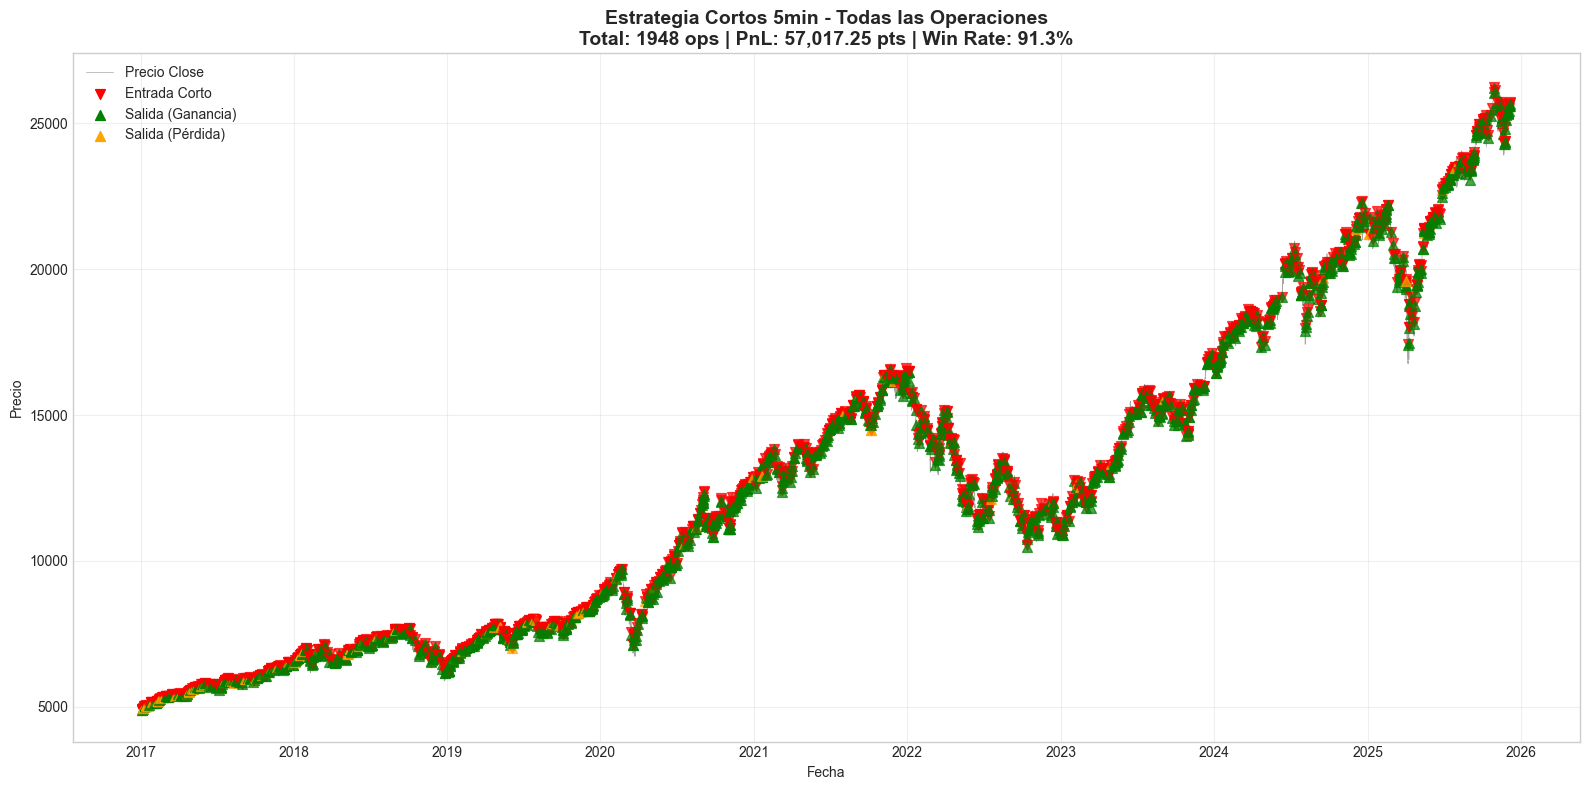

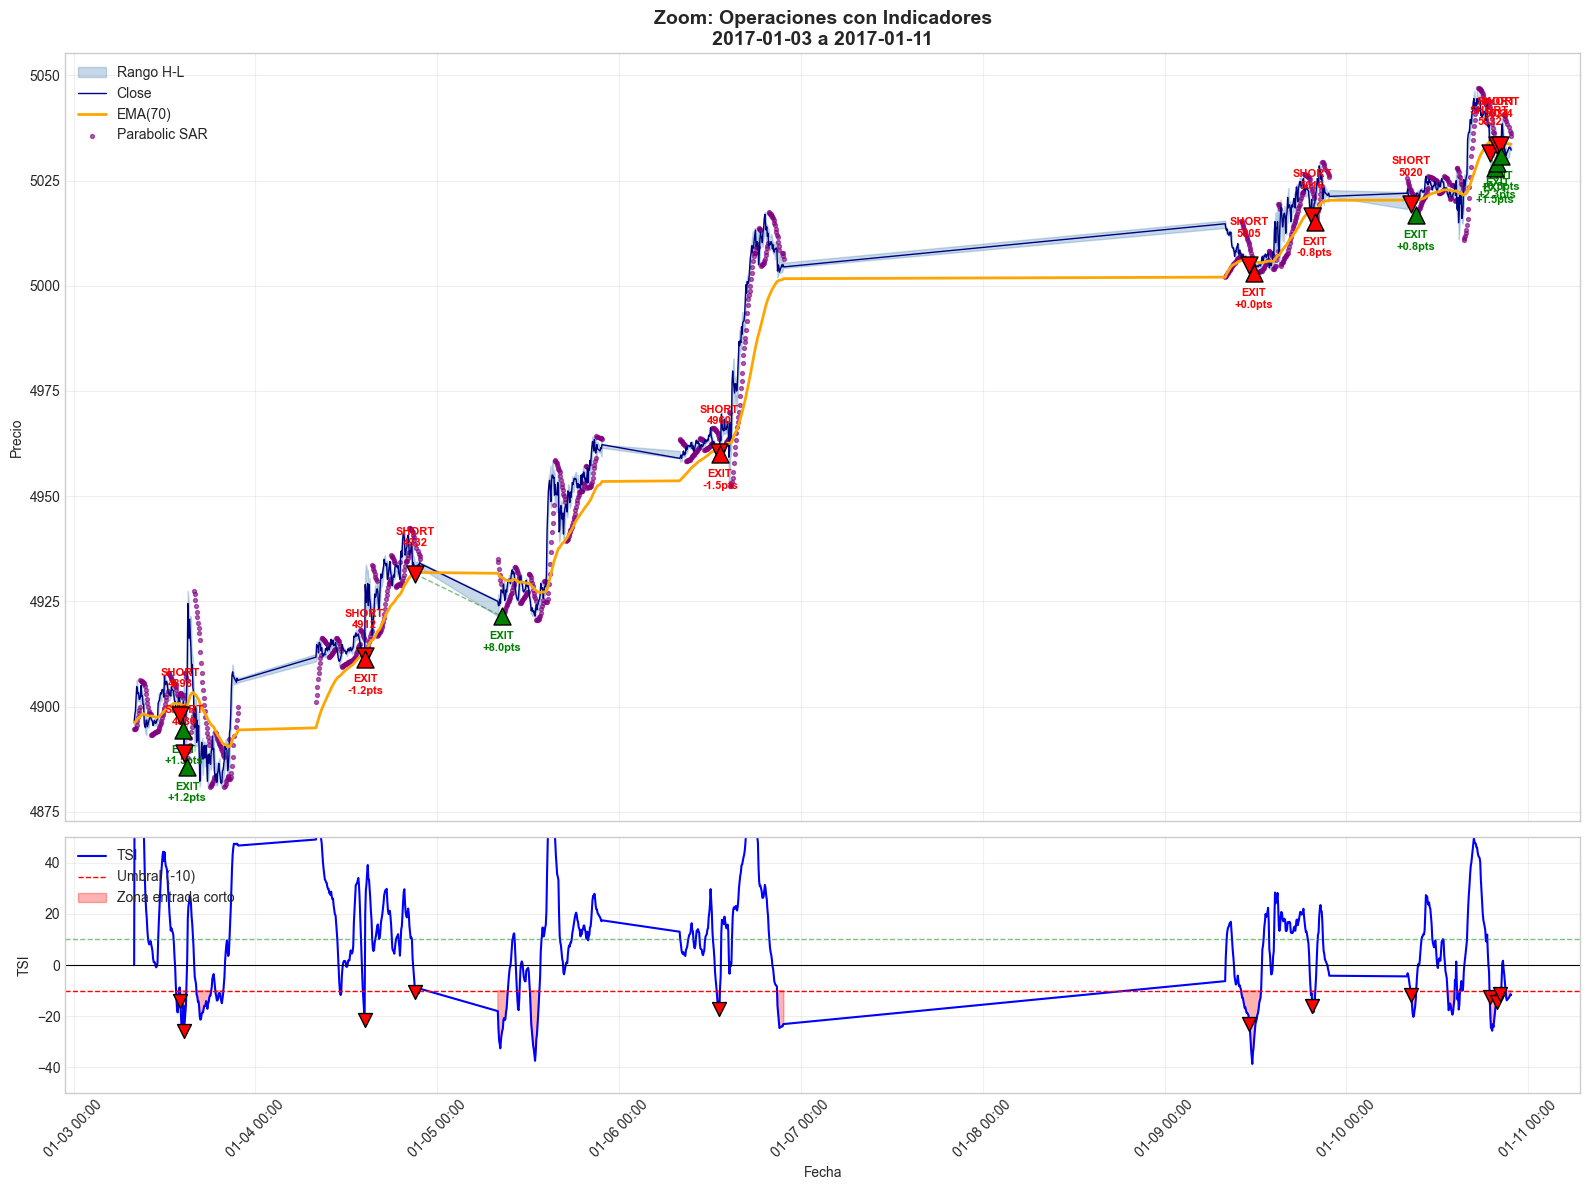

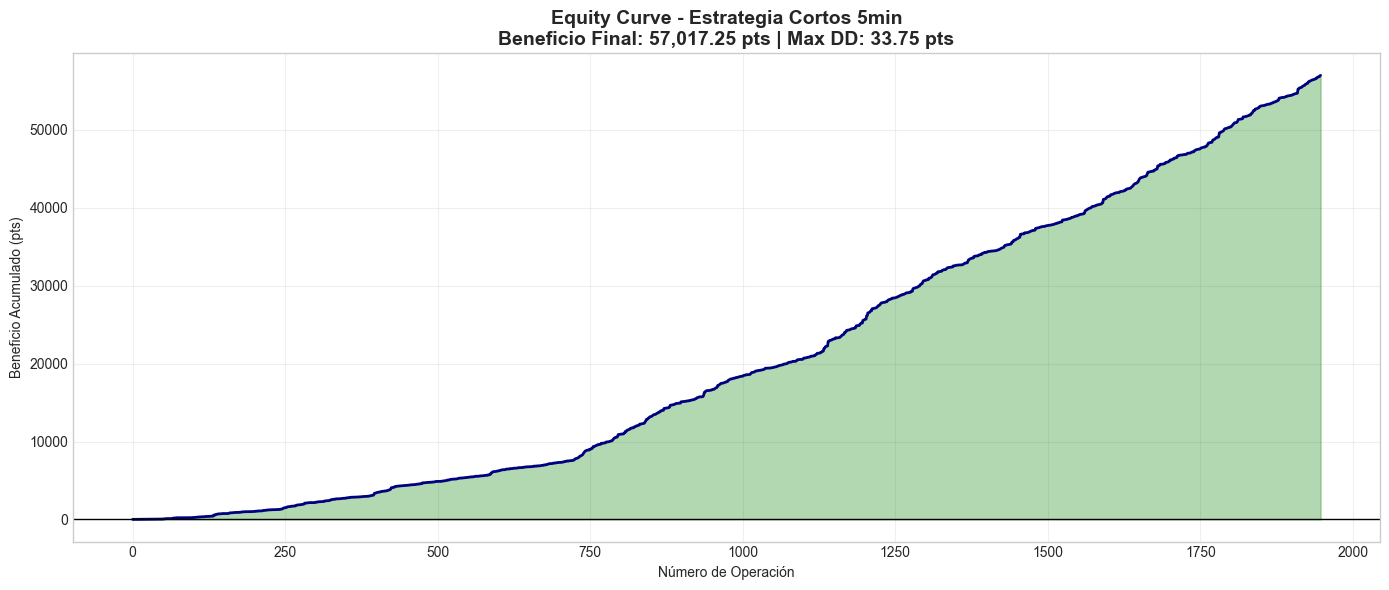


ÚLTIMAS 20 OPERACIONES
         Entrada           Salida  Precio Ent.  Precio Sal.  PnL (pts)
2025-11-19 13:35 2025-11-19 13:40     24672.25 24643.373500  26.876500
2025-11-21 20:50 2025-11-21 21:35     24325.50 24285.000000  38.500000
2025-11-21 21:45 2025-11-24 08:00     24335.75 24293.188088  40.561912
2025-11-24 10:10 2025-11-24 10:40     24403.25 24361.750000  39.500000
2025-11-24 10:50 2025-11-24 10:55     24402.25 24367.953200  32.296800
2025-11-25 08:10 2025-11-25 09:40     24887.75 24822.000000  63.750000
2025-11-26 12:05 2025-11-26 12:45     25133.50 25118.500000  13.000000
2025-11-27 08:05 2025-11-27 08:15     25298.25 25293.250000   3.000000
2025-12-01 19:25 2025-12-01 20:10     25395.75 25357.000000  36.750000
2025-12-01 20:15 2025-12-01 20:20     25393.75 25359.257200  32.492800
2025-12-01 20:30 2025-12-01 20:35     25395.50 25362.476515  31.023485
2025-12-02 08:00 2025-12-02 08:35     25350.75 25324.750000  24.000000
2025-12-02 17:05 2025-12-02 17:10     25518.00 25420.

In [16]:
# =============================================================================
# BACKTEST ESTRATEGIA CORTOS 5MIN: EMA(70) + TSI + PARABOLIC SAR
# CON VISUALIZACIÓN DE OPERACIONES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

# Configuración
TIMEFRAME = '5min'
SPREAD = 2.0

# Parámetros de indicadores
EMA_PERIOD = 70
TSI_R = 20
TSI_S = 10
TSI_THRESHOLD = -10

# Parabolic SAR
PSAR_START = 0.02
PSAR_INCREMENT = 0.02
PSAR_MAXIMUM = 0.2

# Horario de trading (GMT)
TRADING_START = 8
TRADING_END = 21

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

def resample_ohlcv(df, timeframe):
    if timeframe == '1min': 
        return df.copy()
    return df.resample(timeframe).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()


def calculate_tsi(df, r=20, s=10):
    diff = df['close'].diff()
    ema1_diff = diff.ewm(span=r, adjust=False).mean()
    ema1_abs_diff = diff.abs().ewm(span=r, adjust=False).mean()
    ema2_diff = ema1_diff.ewm(span=s, adjust=False).mean()
    ema2_abs_diff = ema1_abs_diff.ewm(span=s, adjust=False).mean()
    tsi = 100 * (ema2_diff / ema2_abs_diff.replace(0, np.nan))
    return tsi.fillna(0)


def calculate_parabolic_sar(df, start=0.02, increment=0.02, maximum=0.2):
    high = df['high'].values
    low = df['low'].values
    n = len(df)
    
    psar = np.zeros(n)
    af = start
    trend = 1
    
    psar[0] = low[0] if trend == 1 else high[0]
    ep = high[0] if trend == 1 else low[0]
    
    for i in range(1, n):
        psar[i] = psar[i-1] + af * (ep - psar[i-1])
        
        if trend == 1:
            psar[i] = min(psar[i], low[i-1])
            if i > 1:
                psar[i] = min(psar[i], low[i-2])
            
            if low[i] < psar[i]:
                trend = -1
                psar[i] = ep
                ep = low[i]
                af = start
            else:
                if high[i] > ep:
                    ep = high[i]
                    af = min(af + increment, maximum)
        else:
            psar[i] = max(psar[i], high[i-1])
            if i > 1:
                psar[i] = max(psar[i], high[i-2])
            
            if high[i] > psar[i]:
                trend = 1
                psar[i] = ep
                ep = high[i]
                af = start
            else:
                if low[i] < ep:
                    ep = low[i]
                    af = min(af + increment, maximum)
    
    return pd.Series(psar, index=df.index)


def filter_trading_hours(df):
    df_filtered = df.copy()
    if df_filtered.index.tz is not None and str(df_filtered.index.tz) != 'UTC':
        df_filtered.index = df_filtered.index.tz_convert('UTC')
    
    hour = df_filtered.index.hour
    minute = df_filtered.index.minute
    
    mask = (
        ((hour >= TRADING_START) & (hour < TRADING_END)) |
        ((hour == TRADING_END) & (minute <= 45))
    )
    return df_filtered[mask]


print("="*70)
print("ESTRATEGIA CORTOS 5MIN: EMA(70) + TSI + PARABOLIC SAR")
print("="*70)

# =============================================================================
# PREPARAR DATOS
# =============================================================================

# Resamplear a 5 minutos
df_5m = resample_ohlcv(df_1m, TIMEFRAME)

# Filtrar horario de trading
df_5m = filter_trading_hours(df_5m)

print(f"Datos 5min filtrados: {len(df_5m):,} barras")
print(f"Desde: {df_5m.index.min()}")
print(f"Hasta: {df_5m.index.max()}")

# Calcular indicadores
df_5m['EMA_70'] = df_5m['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
df_5m['TSI'] = calculate_tsi(df_5m, r=TSI_R, s=TSI_S)
df_5m['PSAR'] = calculate_parabolic_sar(df_5m, PSAR_START, PSAR_INCREMENT, PSAR_MAXIMUM)

# Condiciones de señal
df_5m['EMA_prev'] = df_5m['EMA_70'].shift(1)
df_5m['EMA_descendente'] = df_5m['EMA_70'] < df_5m['EMA_prev']
df_5m['close_prev'] = df_5m['close'].shift(1)
df_5m['cruce_bajista'] = (df_5m['close_prev'] > df_5m['EMA_prev']) & (df_5m['close'] < df_5m['EMA_70'])

signal_short = (
    df_5m['cruce_bajista'] &
    df_5m['EMA_descendente'] &
    (df_5m['TSI'] < TSI_THRESHOLD)
)

# =============================================================================
# SIMULACIÓN DE TRADES
# =============================================================================

trades = []
in_position = False
entry_price = 0.0
entry_date = None
entry_idx = None

short_arr = signal_short.values
close_arr = df_5m['close'].values
high_arr = df_5m['high'].values
psar_arr = df_5m['PSAR'].values
dates_arr = df_5m.index

for i in range(len(df_5m)):
    if not in_position:
        if short_arr[i]:
            in_position = True
            entry_price = close_arr[i]
            entry_date = dates_arr[i]
            entry_idx = i
    else:
        if high_arr[i] >= psar_arr[i]:
            in_position = False
            exit_price = min(psar_arr[i], high_arr[i])
            pnl_pts = entry_price - exit_price - SPREAD
            
            trades.append({
                'entry_date': entry_date,
                'exit_date': dates_arr[i],
                'entry_idx': entry_idx,
                'exit_idx': i,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl_pts': pnl_pts
            })

df_trades = pd.DataFrame(trades)

# =============================================================================
# ESTADÍSTICAS
# =============================================================================

print("\n" + "="*70)
print("ESTADÍSTICAS DE LA ESTRATEGIA")
print("="*70)

if len(df_trades) > 0:
    total_pnl = df_trades['pnl_pts'].sum()
    win_trades = df_trades[df_trades['pnl_pts'] > 0]
    loss_trades = df_trades[df_trades['pnl_pts'] <= 0]
    
    win_rate = len(win_trades) / len(df_trades)
    
    gross_profit = win_trades['pnl_pts'].sum() if len(win_trades) > 0 else 0
    gross_loss = abs(loss_trades['pnl_pts'].sum()) if len(loss_trades) > 0 else 0
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    
    avg_win = win_trades['pnl_pts'].mean() if len(win_trades) > 0 else 0
    avg_loss = loss_trades['pnl_pts'].mean() if len(loss_trades) > 0 else 0
    
    # Max Drawdown
    equity = df_trades['pnl_pts'].cumsum()
    running_max = equity.cummax()
    drawdown = running_max - equity
    max_dd = drawdown.max()
    
    # Duración media de trades
    df_trades['duration'] = df_trades['exit_date'] - df_trades['entry_date']
    avg_duration = df_trades['duration'].mean()
    
    print(f"\n📊 Operaciones totales: {len(df_trades)}")
    print(f"   ├─ Ganadoras: {len(win_trades)} ({win_rate:.1%})")
    print(f"   └─ Perdedoras: {len(loss_trades)} ({1-win_rate:.1%})")
    print(f"\n💰 Beneficio total: {total_pnl:,.2f} pts")
    print(f"   ├─ Beneficio bruto: {gross_profit:,.2f} pts")
    print(f"   └─ Pérdida bruta: -{gross_loss:,.2f} pts")
    print(f"\n📈 Profit Factor: {profit_factor:.2f}")
    print(f"📉 Max Drawdown: {max_dd:,.2f} pts")
    print(f"\n⏱️  Duración media: {avg_duration}")
    print(f"   ├─ Ganancia media: {avg_win:,.2f} pts")
    print(f"   └─ Pérdida media: {avg_loss:,.2f} pts")

# =============================================================================
# GRÁFICO 1: PRECIO COMPLETO CON OPERACIONES
# =============================================================================

print("\n" + "="*70)
print("GENERANDO GRÁFICOS...")
print("="*70)

fig1, ax1 = plt.subplots(figsize=(16, 8))

# Precio de cierre
ax1.plot(df_5m.index, df_5m['close'], color='gray', alpha=0.7, linewidth=0.5, label='Precio Close')

# Marcar entradas y salidas
for _, trade in df_trades.iterrows():
    # Entrada (flecha hacia abajo roja - venta/corto)
    ax1.scatter(trade['entry_date'], trade['entry_price'], 
                marker='v', color='red', s=50, zorder=5, alpha=0.7)
    
    # Salida (flecha hacia arriba verde - compra/cierre)
    color_exit = 'green' if trade['pnl_pts'] > 0 else 'orange'
    ax1.scatter(trade['exit_date'], trade['exit_price'], 
                marker='^', color=color_exit, s=50, zorder=5, alpha=0.7)

# Leyenda
ax1.scatter([], [], marker='v', color='red', s=50, label='Entrada Corto')
ax1.scatter([], [], marker='^', color='green', s=50, label='Salida (Ganancia)')
ax1.scatter([], [], marker='^', color='orange', s=50, label='Salida (Pérdida)')

ax1.set_title(f'Estrategia Cortos 5min - Todas las Operaciones\n'
              f'Total: {len(df_trades)} ops | PnL: {total_pnl:,.2f} pts | Win Rate: {win_rate:.1%}', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/estrategia_cortos_5min_completo.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# GRÁFICO 2: ZOOM CON INDICADORES Y OPERACIONES
# =============================================================================

# Seleccionar un período con operaciones para el zoom
# Buscar un período con varias operaciones
if len(df_trades) > 0:
    # Encontrar un período con múltiples operaciones cercanas
    # Usar las primeras 10-20 operaciones o un período específico
    
    # Opción: tomar un rango alrededor de algunas operaciones
    sample_trades = df_trades.head(min(10, len(df_trades)))
    
    if len(sample_trades) > 0:
        start_zoom = sample_trades.iloc[0]['entry_date'] - pd.Timedelta(hours=12)
        end_zoom = sample_trades.iloc[-1]['exit_date'] + pd.Timedelta(hours=12)
        
        # Filtrar datos para el zoom
        mask_zoom = (df_5m.index >= start_zoom) & (df_5m.index <= end_zoom)
        df_zoom = df_5m[mask_zoom]
        
        # Filtrar trades en este período
        trades_zoom = df_trades[
            (df_trades['entry_date'] >= start_zoom) & 
            (df_trades['exit_date'] <= end_zoom)
        ]
        
        if len(df_zoom) > 50:  # Asegurar suficientes datos
            
            fig2, axes = plt.subplots(2, 1, figsize=(16, 12), height_ratios=[3, 1], sharex=True)
            
            # --- Panel Superior: Precio, EMA, PSAR y Operaciones ---
            ax_price = axes[0]
            
            # Precio con velas simplificadas (línea con relleno)
            ax_price.fill_between(df_zoom.index, df_zoom['low'], df_zoom['high'], 
                                  alpha=0.3, color='steelblue', label='Rango H-L')
            ax_price.plot(df_zoom.index, df_zoom['close'], color='navy', 
                         linewidth=1, label='Close')
            
            # EMA 70
            ax_price.plot(df_zoom.index, df_zoom['EMA_70'], color='orange', 
                         linewidth=2, label=f'EMA({EMA_PERIOD})')
            
            # Parabolic SAR
            ax_price.scatter(df_zoom.index, df_zoom['PSAR'], color='purple', 
                           s=8, alpha=0.6, label='Parabolic SAR')
            
            # Operaciones en el zoom
            for _, trade in trades_zoom.iterrows():
                # Entrada
                ax_price.scatter(trade['entry_date'], trade['entry_price'], 
                               marker='v', color='red', s=150, zorder=10, 
                               edgecolors='black', linewidths=1)
                ax_price.annotate(f"SHORT\n{trade['entry_price']:.0f}", 
                                xy=(trade['entry_date'], trade['entry_price']),
                                xytext=(0, 20), textcoords='offset points',
                                fontsize=8, ha='center', color='red', fontweight='bold')
                
                # Salida
                color_exit = 'green' if trade['pnl_pts'] > 0 else 'red'
                ax_price.scatter(trade['exit_date'], trade['exit_price'], 
                               marker='^', color=color_exit, s=150, zorder=10,
                               edgecolors='black', linewidths=1)
                ax_price.annotate(f"EXIT\n{trade['pnl_pts']:+.1f}pts", 
                                xy=(trade['exit_date'], trade['exit_price']),
                                xytext=(0, -25), textcoords='offset points',
                                fontsize=8, ha='center', color=color_exit, fontweight='bold')
                
                # Línea conectando entrada y salida
                ax_price.plot([trade['entry_date'], trade['exit_date']], 
                            [trade['entry_price'], trade['exit_price']], 
                            color=color_exit, linestyle='--', alpha=0.5, linewidth=1)
            
            ax_price.set_title(f'Zoom: Operaciones con Indicadores\n'
                              f'{start_zoom.strftime("%Y-%m-%d")} a {end_zoom.strftime("%Y-%m-%d")}', 
                              fontsize=14, fontweight='bold')
            ax_price.set_ylabel('Precio')
            ax_price.legend(loc='upper left')
            ax_price.grid(True, alpha=0.3)
            
            # --- Panel Inferior: TSI ---
            ax_tsi = axes[1]
            
            ax_tsi.plot(df_zoom.index, df_zoom['TSI'], color='blue', linewidth=1.5, label='TSI')
            ax_tsi.axhline(0, color='black', linewidth=0.8)
            ax_tsi.axhline(TSI_THRESHOLD, color='red', linestyle='--', 
                          linewidth=1, label=f'Umbral ({TSI_THRESHOLD})')
            ax_tsi.axhline(-TSI_THRESHOLD, color='green', linestyle='--', 
                          linewidth=1, alpha=0.5)
            
            # Sombrear zona de entrada (TSI < -10)
            ax_tsi.fill_between(df_zoom.index, TSI_THRESHOLD, df_zoom['TSI'].clip(upper=TSI_THRESHOLD),
                               where=df_zoom['TSI'] < TSI_THRESHOLD, 
                               alpha=0.3, color='red', label='Zona entrada corto')
            
            # Marcar entradas en TSI
            for _, trade in trades_zoom.iterrows():
                entry_tsi = df_5m.loc[trade['entry_date'], 'TSI'] if trade['entry_date'] in df_5m.index else None
                if entry_tsi is not None:
                    ax_tsi.scatter(trade['entry_date'], entry_tsi, 
                                  marker='v', color='red', s=100, zorder=10,
                                  edgecolors='black', linewidths=1)
            
            ax_tsi.set_ylabel('TSI')
            ax_tsi.set_xlabel('Fecha')
            ax_tsi.legend(loc='upper left')
            ax_tsi.grid(True, alpha=0.3)
            ax_tsi.set_ylim(-50, 50)
            
            # Formato de fechas
            ax_tsi.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.savefig('../output/estrategia_cortos_5min_zoom.png', dpi=150, bbox_inches='tight')
            plt.show()

# =============================================================================
# GRÁFICO 3: EQUITY CURVE
# =============================================================================

if len(df_trades) > 0:
    fig3, ax3 = plt.subplots(figsize=(14, 6))
    
    equity_curve = df_trades['pnl_pts'].cumsum()
    
    # Colorear según beneficio/pérdida
    colors = ['green' if x >= 0 else 'red' for x in equity_curve]
    
    ax3.fill_between(range(len(equity_curve)), 0, equity_curve, 
                     where=equity_curve >= 0, alpha=0.3, color='green')
    ax3.fill_between(range(len(equity_curve)), 0, equity_curve, 
                     where=equity_curve < 0, alpha=0.3, color='red')
    ax3.plot(equity_curve.values, color='navy', linewidth=2)
    
    ax3.axhline(0, color='black', linewidth=1)
    ax3.set_title(f'Equity Curve - Estrategia Cortos 5min\n'
                  f'Beneficio Final: {total_pnl:,.2f} pts | Max DD: {max_dd:,.2f} pts', 
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel('Número de Operación')
    ax3.set_ylabel('Beneficio Acumulado (pts)')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../output/estrategia_cortos_5min_equity.png', dpi=150, bbox_inches='tight')
    plt.show()

# =============================================================================
# TABLA DE ÚLTIMAS OPERACIONES
# =============================================================================

print("\n" + "="*70)
print("ÚLTIMAS 20 OPERACIONES")
print("="*70)

if len(df_trades) > 0:
    df_display = df_trades.tail(20)[['entry_date', 'exit_date', 'entry_price', 'exit_price', 'pnl_pts']].copy()
    df_display['entry_date'] = df_display['entry_date'].dt.strftime('%Y-%m-%d %H:%M')
    df_display['exit_date'] = df_display['exit_date'].dt.strftime('%Y-%m-%d %H:%M')
    df_display.columns = ['Entrada', 'Salida', 'Precio Ent.', 'Precio Sal.', 'PnL (pts)']
    print(df_display.to_string(index=False))

print("\n✅ Gráficos guardados en ../output/")

In [17]:
# =============================================================================
# ESTRATEGIA CORTOS 5MIN - IMAGEN VECTORIZADA SVG
# GUARDA EN ESCRITORIO (RUTA ABSOLUTA)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pathlib import Path
import os

# =============================================================================
# CONFIGURAR RUTA DE GUARDADO - MODIFICA AQUÍ SI ES NECESARIO
# =============================================================================

# Detectar usuario y crear ruta al Escritorio
usuario = os.path.expanduser("~")  # /Users/tu_usuario en Mac
CARPETA_DESTINO = Path(usuario) / "Desktop"  # Escritorio

# Si prefieres otra carpeta, descomenta y modifica:
# CARPETA_DESTINO = Path("/Users/emiliosanchez/Desktop/pruebas_paco/test_TSI/output")

print(f"📁 Los archivos se guardarán en: {CARPETA_DESTINO}")

# =============================================================================
# PARÁMETROS
# =============================================================================

TIMEFRAME = '5min'
SPREAD = 2.0
EMA_PERIOD = 70
TSI_R = 20
TSI_S = 10
TSI_THRESHOLD = -10
PSAR_START = 0.02
PSAR_INCREMENT = 0.02
PSAR_MAXIMUM = 0.2
TRADING_START = 8
TRADING_END = 21

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8

# =============================================================================
# FUNCIONES
# =============================================================================

def resample_ohlcv(df, timeframe):
    if timeframe == '1min': 
        return df.copy()
    return df.resample(timeframe).agg({
        'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'
    }).dropna()

def calculate_tsi(df, r=20, s=10):
    diff = df['close'].diff()
    ema1_diff = diff.ewm(span=r, adjust=False).mean()
    ema1_abs_diff = diff.abs().ewm(span=r, adjust=False).mean()
    ema2_diff = ema1_diff.ewm(span=s, adjust=False).mean()
    ema2_abs_diff = ema1_abs_diff.ewm(span=s, adjust=False).mean()
    return (100 * (ema2_diff / ema2_abs_diff.replace(0, np.nan))).fillna(0)

def calculate_parabolic_sar(df, start=0.02, increment=0.02, maximum=0.2):
    high, low = df['high'].values, df['low'].values
    n = len(df)
    psar = np.zeros(n)
    af, trend = start, 1
    psar[0] = low[0]
    ep = high[0]
    
    for i in range(1, n):
        psar[i] = psar[i-1] + af * (ep - psar[i-1])
        if trend == 1:
            psar[i] = min(psar[i], low[i-1], low[i-2] if i > 1 else low[i-1])
            if low[i] < psar[i]:
                trend, psar[i], ep, af = -1, ep, low[i], start
            elif high[i] > ep:
                ep, af = high[i], min(af + increment, maximum)
        else:
            psar[i] = max(psar[i], high[i-1], high[i-2] if i > 1 else high[i-1])
            if high[i] > psar[i]:
                trend, psar[i], ep, af = 1, ep, high[i], start
            elif low[i] < ep:
                ep, af = low[i], min(af + increment, maximum)
    return pd.Series(psar, index=df.index)

def filter_trading_hours(df):
    df_f = df.copy()
    if df_f.index.tz is not None and str(df_f.index.tz) != 'UTC':
        df_f.index = df_f.index.tz_convert('UTC')
    hour, minute = df_f.index.hour, df_f.index.minute
    mask = ((hour >= TRADING_START) & (hour < TRADING_END)) | ((hour == TRADING_END) & (minute <= 45))
    return df_f[mask]

# =============================================================================
# PREPARAR DATOS
# =============================================================================

print("Preparando datos...")
df_5m = filter_trading_hours(resample_ohlcv(df_1m, TIMEFRAME))

df_5m['EMA_70'] = df_5m['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
df_5m['TSI'] = calculate_tsi(df_5m, r=TSI_R, s=TSI_S)
df_5m['PSAR'] = calculate_parabolic_sar(df_5m, PSAR_START, PSAR_INCREMENT, PSAR_MAXIMUM)

# Señales
df_5m['EMA_prev'] = df_5m['EMA_70'].shift(1)
df_5m['close_prev'] = df_5m['close'].shift(1)
signal_short = (
    ((df_5m['close_prev'] > df_5m['EMA_prev']) & (df_5m['close'] < df_5m['EMA_70'])) &
    (df_5m['EMA_70'] < df_5m['EMA_prev']) &
    (df_5m['TSI'] < TSI_THRESHOLD)
)

# Simular trades
trades = []
in_position = False

for i in range(len(df_5m)):
    if not in_position and signal_short.iloc[i]:
        in_position = True
        entry_price = df_5m['close'].iloc[i]
        entry_date = df_5m.index[i]
    elif in_position and df_5m['high'].iloc[i] >= df_5m['PSAR'].iloc[i]:
        in_position = False
        exit_price = min(df_5m['PSAR'].iloc[i], df_5m['high'].iloc[i])
        trades.append({
            'entry_date': entry_date, 'exit_date': df_5m.index[i],
            'entry_price': entry_price, 'exit_price': exit_price,
            'pnl_pts': entry_price - exit_price - SPREAD
        })

df_trades = pd.DataFrame(trades)
print(f"Total operaciones: {len(df_trades)}")

# =============================================================================
# SELECCIONAR PERÍODO (30 días con más operaciones)
# =============================================================================

DIAS_VISUALIZAR = 30

if len(df_trades) > 0:
    df_trades['month'] = df_trades['entry_date'].dt.to_period('M')
    best_month = df_trades.groupby('month').size().idxmax()
    trades_month = df_trades[df_trades['month'] == best_month]
    
    start_view = trades_month['entry_date'].min() - pd.Timedelta(days=1)
    end_view = trades_month['exit_date'].max() + pd.Timedelta(days=1)
    
    if (end_view - start_view).days > DIAS_VISUALIZAR:
        end_view = start_view + pd.Timedelta(days=DIAS_VISUALIZAR)
    
    df_view = df_5m[(df_5m.index >= start_view) & (df_5m.index <= end_view)].copy()
    trades_view = df_trades[(df_trades['entry_date'] >= start_view) & (df_trades['exit_date'] <= end_view)]
    
    print(f"Período: {start_view.strftime('%Y-%m-%d')} a {end_view.strftime('%Y-%m-%d')}")
    print(f"Operaciones en vista: {len(trades_view)}")

# =============================================================================
# CREAR FIGURA
# =============================================================================

print("\nGenerando imagen vectorial...")

fig, axes = plt.subplots(2, 1, figsize=(24, 14), height_ratios=[3, 1], 
                          gridspec_kw={'hspace': 0.03})

# --- PANEL PRECIO ---
ax1 = axes[0]
ax1.set_facecolor('#fafafa')

ax1.plot(df_view.index, df_view['close'], color='#37474f', linewidth=0.6, alpha=0.9, label='Precio', zorder=2)
ax1.plot(df_view.index, df_view['EMA_70'], color='#ff6f00', linewidth=1.5, label=f'EMA({EMA_PERIOD})', zorder=3)
ax1.scatter(df_view.index, df_view['PSAR'], color='#7b1fa2', s=3, marker='.', alpha=0.5, label='Parabolic SAR', zorder=1)

for _, trade in trades_view.iterrows():
    is_win = trade['pnl_pts'] > 0
    ax1.scatter(trade['entry_date'], trade['entry_price'], marker='v', color='#c62828', s=80, zorder=10, edgecolors='black', linewidths=0.5)
    exit_color = '#2e7d32' if is_win else '#c62828'
    ax1.scatter(trade['exit_date'], trade['exit_price'], marker='^', color=exit_color, s=80, zorder=10, edgecolors='black', linewidths=0.5)
    ax1.plot([trade['entry_date'], trade['exit_date']], [trade['entry_price'], trade['exit_price']], color=exit_color, linestyle='-', alpha=0.4, linewidth=0.8, zorder=5)

ax1.set_ylabel('Precio NQ', fontsize=11, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3, linewidth=0.3)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax1.tick_params(axis='x', labelbottom=False)

total_pnl = trades_view['pnl_pts'].sum() if len(trades_view) > 0 else 0
win_rate = (trades_view['pnl_pts'] > 0).mean() if len(trades_view) > 0 else 0
ax1.set_title(f'Estrategia Cortos NQ 5min | EMA(70) + TSI({TSI_R},{TSI_S}) + Parabolic SAR\n'
              f'{start_view.strftime("%Y-%m-%d")} → {end_view.strftime("%Y-%m-%d")} | '
              f'Ops: {len(trades_view)} | PnL: {total_pnl:+,.1f} pts | WR: {win_rate:.0%}',
              fontsize=13, fontweight='bold')

# --- PANEL TSI ---
ax2 = axes[1]
ax2.set_facecolor('#fafafa')
ax2.plot(df_view.index, df_view['TSI'], color='#1565c0', linewidth=1, label='TSI')
ax2.axhline(0, color='black', linewidth=0.8)
ax2.axhline(TSI_THRESHOLD, color='#c62828', linestyle='--', linewidth=1, label=f'Umbral ({TSI_THRESHOLD})')
ax2.fill_between(df_view.index, TSI_THRESHOLD, df_view['TSI'].clip(upper=TSI_THRESHOLD),
                 where=df_view['TSI'] < TSI_THRESHOLD, alpha=0.2, color='#c62828')

for _, trade in trades_view.iterrows():
    if trade['entry_date'] in df_view.index:
        ax2.scatter(trade['entry_date'], df_view.loc[trade['entry_date'], 'TSI'], 
                   marker='v', color='#c62828', s=60, zorder=10, edgecolors='black', linewidths=0.5)

ax2.set_ylabel('TSI', fontsize=11, fontweight='bold')
ax2.set_xlabel('Fecha', fontsize=11, fontweight='bold')
ax2.set_ylim(-50, 50)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3, linewidth=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# =============================================================================
# GUARDAR EN ESCRITORIO
# =============================================================================

svg_path = CARPETA_DESTINO / 'estrategia_cortos_NQ_5min.svg'
pdf_path = CARPETA_DESTINO / 'estrategia_cortos_NQ_5min.pdf'

fig.savefig(svg_path, format='svg', bbox_inches='tight', facecolor='white')
fig.savefig(pdf_path, format='pdf', bbox_inches='tight', facecolor='white')

plt.close(fig)

# =============================================================================
# CONFIRMACIÓN
# =============================================================================

print("\n" + "="*70)
print("✅ ¡ARCHIVOS GUARDADOS EN TU ESCRITORIO!")
print("="*70)
print(f"\n📐 SVG: {svg_path}")
print(f"📐 PDF: {pdf_path}")
print("\nAbre el Finder y ve a tu Escritorio. Deberías ver:")
print("   - estrategia_cortos_NQ_5min.svg")
print("   - estrategia_cortos_NQ_5min.pdf")
print("\nEl SVG lo puedes abrir con:")
print("   - Navegador web (Chrome, Safari, Firefox)")
print("   - Adobe Illustrator")
print("   - Inkscape (gratis)")
print("   - Affinity Designer")

# Verificar que existen
if svg_path.exists():
    print(f"\n✅ Verificado: SVG existe ({svg_path.stat().st_size / 1024:.1f} KB)")
if pdf_path.exists():
    print(f"✅ Verificado: PDF existe ({pdf_path.stat().st_size / 1024:.1f} KB)")

📁 Los archivos se guardarán en: /Users/emiliosanchez/Desktop
Preparando datos...
Total operaciones: 1948
Período: 2019-01-01 a 2019-01-31
Operaciones en vista: 29

Generando imagen vectorial...


/var/folders/50/sdzdcy5967d0c1p38yd6p3_00000gn/T/ipykernel_85443/3324228895.py:148: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_trades['month'] = df_trades['entry_date'].dt.to_period('M')



✅ ¡ARCHIVOS GUARDADOS EN TU ESCRITORIO!

📐 SVG: /Users/emiliosanchez/Desktop/estrategia_cortos_NQ_5min.svg
📐 PDF: /Users/emiliosanchez/Desktop/estrategia_cortos_NQ_5min.pdf

Abre el Finder y ve a tu Escritorio. Deberías ver:
   - estrategia_cortos_NQ_5min.svg
   - estrategia_cortos_NQ_5min.pdf

El SVG lo puedes abrir con:
   - Navegador web (Chrome, Safari, Firefox)
   - Adobe Illustrator
   - Inkscape (gratis)
   - Affinity Designer

✅ Verificado: SVG existe (745.6 KB)
✅ Verificado: PDF existe (127.8 KB)


In [18]:
# =============================================================================
# BACKTEST ESTRATEGIA CORTOS: EMA(70) + TSI + PARABOLIC SAR
# CON DETALLE DE OPERACIONES POR TIMEFRAME
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuración
TIMEFRAMES = ['2min', '5min', '10min', '15min', '30min', '1h', '4h', '1D']
SPREAD = 2.0

# Parámetros de indicadores
EMA_PERIOD = 70
TSI_R = 20
TSI_S = 10
TSI_THRESHOLD = -10

# Parabolic SAR
PSAR_START = 0.02
PSAR_INCREMENT = 0.02
PSAR_MAXIMUM = 0.2

# Horario de trading (GMT)
TRADING_START = 8
TRADING_END = 21

# Diccionario para guardar todos los trades por timeframe
all_trades_by_tf = {}
all_results_short = []

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

def resample_ohlcv(df, timeframe):
    if timeframe == '1min': 
        return df.copy()
    return df.resample(timeframe).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()


def calculate_tsi(df, r=20, s=10):
    diff = df['close'].diff()
    ema1_diff = diff.ewm(span=r, adjust=False).mean()
    ema1_abs_diff = diff.abs().ewm(span=r, adjust=False).mean()
    ema2_diff = ema1_diff.ewm(span=s, adjust=False).mean()
    ema2_abs_diff = ema1_abs_diff.ewm(span=s, adjust=False).mean()
    tsi = 100 * (ema2_diff / ema2_abs_diff.replace(0, np.nan))
    return tsi.fillna(0)


def calculate_parabolic_sar(df, start=0.02, increment=0.02, maximum=0.2):
    high = df['high'].values
    low = df['low'].values
    n = len(df)
    
    psar = np.zeros(n)
    af = start
    trend = 1
    
    psar[0] = low[0] if trend == 1 else high[0]
    ep = high[0] if trend == 1 else low[0]
    
    for i in range(1, n):
        psar[i] = psar[i-1] + af * (ep - psar[i-1])
        
        if trend == 1:
            psar[i] = min(psar[i], low[i-1])
            if i > 1:
                psar[i] = min(psar[i], low[i-2])
            
            if low[i] < psar[i]:
                trend = -1
                psar[i] = ep
                ep = low[i]
                af = start
            else:
                if high[i] > ep:
                    ep = high[i]
                    af = min(af + increment, maximum)
        else:
            psar[i] = max(psar[i], high[i-1])
            if i > 1:
                psar[i] = max(psar[i], high[i-2])
            
            if high[i] > psar[i]:
                trend = 1
                psar[i] = ep
                ep = high[i]
                af = start
            else:
                if low[i] < ep:
                    ep = low[i]
                    af = min(af + increment, maximum)
    
    return pd.Series(psar, index=df.index)


def filter_trading_hours(df):
    df_filtered = df.copy()
    
    if df_filtered.index.tz is not None and str(df_filtered.index.tz) != 'UTC':
        df_filtered.index = df_filtered.index.tz_convert('UTC')
    
    hour = df_filtered.index.hour
    minute = df_filtered.index.minute
    
    mask = (
        ((hour >= TRADING_START) & (hour < TRADING_END)) |
        ((hour == TRADING_END) & (minute <= 45))
    )
    
    return df_filtered[mask]


print("="*70)
print("ESTRATEGIA CORTOS: EMA(70) + TSI + PARABOLIC SAR")
print("="*70)
print(f"Entrada corto: Precio cruza EMA(70) hacia abajo + EMA descendente + TSI < {TSI_THRESHOLD}")
print(f"Salida: Precio toca Parabolic SAR")
print(f"Horario: {TRADING_START}:00 - {TRADING_END}:45 GMT | Spread: {SPREAD} pts")
print("="*70 + "\n")

# =============================================================================
# BUCLE PRINCIPAL
# =============================================================================

for tf in TIMEFRAMES:
    try:
        # 1. Resamplear
        df_tf = resample_ohlcv(df_1m, tf)
        
        # 2. Filtrar horario de trading
        df_tf = filter_trading_hours(df_tf)
        
        if len(df_tf) < EMA_PERIOD + 10:
            print(f"⚠️ {tf}: Insuficientes datos ({len(df_tf)} barras)")
            continue
        
        # 3. Calcular indicadores
        df_tf['EMA_70'] = df_tf['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
        df_tf['TSI'] = calculate_tsi(df_tf, r=TSI_R, s=TSI_S)
        df_tf['PSAR'] = calculate_parabolic_sar(df_tf, PSAR_START, PSAR_INCREMENT, PSAR_MAXIMUM)
        
        # 4. Calcular condiciones de señal
        df_tf['EMA_prev'] = df_tf['EMA_70'].shift(1)
        df_tf['EMA_descendente'] = df_tf['EMA_70'] < df_tf['EMA_prev']
        df_tf['close_prev'] = df_tf['close'].shift(1)
        df_tf['cruce_bajista'] = (df_tf['close_prev'] > df_tf['EMA_prev']) & (df_tf['close'] < df_tf['EMA_70'])
        
        signal_short = (
            df_tf['cruce_bajista'] &
            df_tf['EMA_descendente'] &
            (df_tf['TSI'] < TSI_THRESHOLD)
        )
        
        # 5. Simulación de Trades con detalle completo
        trades_details = []
        
        in_position = False
        entry_price = 0.0
        entry_date = None
        entry_tsi = 0.0
        entry_ema = 0.0
        
        short_arr = signal_short.values
        close_arr = df_tf['close'].values
        high_arr = df_tf['high'].values
        psar_arr = df_tf['PSAR'].values
        tsi_arr = df_tf['TSI'].values
        ema_arr = df_tf['EMA_70'].values
        dates_arr = df_tf.index
        
        for i in range(len(df_tf)):
            if not in_position:
                if short_arr[i]:
                    in_position = True
                    entry_price = close_arr[i]
                    entry_date = dates_arr[i]
                    entry_tsi = tsi_arr[i]
                    entry_ema = ema_arr[i]
            else:
                if high_arr[i] >= psar_arr[i]:
                    in_position = False
                    exit_price = min(psar_arr[i], high_arr[i])
                    pnl_pts = entry_price - exit_price - SPREAD
                    
                    # Calcular duración
                    duration = dates_arr[i] - entry_date
                    
                    trades_details.append({
                        'Timeframe': tf,
                        'Fecha Entrada': entry_date,
                        'Fecha Salida': dates_arr[i],
                        'Duración': duration,
                        'Precio Entrada': entry_price,
                        'Precio Salida': exit_price,
                        'TSI Entrada': entry_tsi,
                        'EMA Entrada': entry_ema,
                        'PSAR Salida': psar_arr[i],
                        'PnL (pts)': pnl_pts,
                        'Resultado': 'WIN' if pnl_pts > 0 else 'LOSS'
                    })
        
        # Guardar trades de este timeframe
        if len(trades_details) > 0:
            all_trades_by_tf[tf] = pd.DataFrame(trades_details)
            
            # Métricas resumen
            trades_np = np.array([t['PnL (pts)'] for t in trades_details])
            total_profit = np.sum(trades_np)
            win_rate = np.sum(trades_np > 0) / len(trades_np)
            
            gross_profit = np.sum(trades_np[trades_np > 0])
            gross_loss = abs(np.sum(trades_np[trades_np < 0]))
            profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
            
            equity = np.cumsum(trades_np)
            max_dd = np.max(np.maximum.accumulate(equity) - equity)
            
            avg_win = np.mean(trades_np[trades_np > 0]) if np.any(trades_np > 0) else 0
            avg_loss = np.mean(trades_np[trades_np < 0]) if np.any(trades_np < 0) else 0
            
            all_results_short.append({
                'Timeframe': tf,
                'Beneficio (Pts)': total_profit,
                'Operaciones': len(trades_details),
                'Win Rate': win_rate,
                'Profit Factor': profit_factor,
                'Max DD (Pts)': max_dd,
                'Avg Win': avg_win,
                'Avg Loss': avg_loss
            })
            
            print(f"✅ {tf:<6} | Pts: {total_profit:>10,.2f} | Ops: {len(trades_details):>5} | "
                  f"WR: {win_rate:.1%} | PF: {profit_factor:.2f}")
        else:
            print(f"⚠️ {tf:<6} | Sin operaciones cerradas")
            
    except Exception as e:
        print(f"❌ Error en {tf}: {str(e)}")
        import traceback
        traceback.print_exc()

# =============================================================================
# RESUMEN GENERAL
# =============================================================================

if all_results_short:
    print("\n" + "="*80)
    print("RESUMEN POR TIMEFRAME")
    print("="*80)
    
    df_res = pd.DataFrame(all_results_short)
    df_res_sorted = df_res.sort_values(by='Beneficio (Pts)', ascending=False)
    
    formatters = {
        'Beneficio (Pts)': '{:>12,.2f}'.format,
        'Operaciones': '{:>6}'.format,
        'Win Rate': '{:>8.1%}'.format,
        'Profit Factor': '{:>8.2f}'.format,
        'Max DD (Pts)': '{:>10,.2f}'.format,
        'Avg Win': '{:>10,.2f}'.format,
        'Avg Loss': '{:>10,.2f}'.format
    }
    
    print(df_res_sorted.to_string(index=False, formatters=formatters))

# =============================================================================
# DETALLE DE OPERACIONES POR TIMEFRAME
# =============================================================================

print("\n" + "="*80)
print("DETALLE DE OPERACIONES POR TIMEFRAME")
print("="*80)

for tf in TIMEFRAMES:
    if tf in all_trades_by_tf:
        df_trades = all_trades_by_tf[tf]
        
        print(f"\n{'='*80}")
        print(f"📊 TIMEFRAME: {tf} | Total operaciones: {len(df_trades)}")
        print(f"{'='*80}")
        
        # Estadísticas rápidas
        wins = len(df_trades[df_trades['Resultado'] == 'WIN'])
        losses = len(df_trades[df_trades['Resultado'] == 'LOSS'])
        total_pnl = df_trades['PnL (pts)'].sum()
        
        print(f"   Ganadoras: {wins} | Perdedoras: {losses} | PnL Total: {total_pnl:,.2f} pts\n")
        
        # Preparar DataFrame para mostrar
        df_display = df_trades.copy()
        df_display['Fecha Entrada'] = df_display['Fecha Entrada'].dt.strftime('%Y-%m-%d %H:%M')
        df_display['Fecha Salida'] = df_display['Fecha Salida'].dt.strftime('%Y-%m-%d %H:%M')
        df_display['Duración'] = df_display['Duración'].astype(str).str.replace('0 days ', '')
        df_display['Precio Entrada'] = df_display['Precio Entrada'].apply(lambda x: f'{x:,.2f}')
        df_display['Precio Salida'] = df_display['Precio Salida'].apply(lambda x: f'{x:,.2f}')
        df_display['TSI Entrada'] = df_display['TSI Entrada'].apply(lambda x: f'{x:.1f}')
        df_display['PnL (pts)'] = df_display['PnL (pts)'].apply(lambda x: f'{x:+,.2f}')
        
        # Seleccionar columnas principales
        cols_mostrar = ['Fecha Entrada', 'Fecha Salida', 'Duración', 
                        'Precio Entrada', 'Precio Salida', 'PnL (pts)', 'Resultado']
        
        print(df_display[cols_mostrar].to_string(index=False))
        print()

# =============================================================================
# EXPORTAR A CSV (OPCIONAL)
# =============================================================================

print("\n" + "="*80)
print("EXPORTAR OPERACIONES A CSV")
print("="*80)

# Combinar todos los trades en un único DataFrame
all_trades_combined = pd.concat(all_trades_by_tf.values(), ignore_index=True)

# Ruta de guardado (Escritorio)
import os
usuario = os.path.expanduser("~")
csv_path = Path(usuario) / "Desktop" / "operaciones_estrategia_cortos.csv"

# Preparar para exportar
df_export = all_trades_combined.copy()
df_export['Fecha Entrada'] = df_export['Fecha Entrada'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_export['Fecha Salida'] = df_export['Fecha Salida'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_export['Duración'] = df_export['Duración'].astype(str)

# Guardar CSV
df_export.to_csv(csv_path, index=False, encoding='utf-8-sig')

print(f"\n✅ CSV guardado en: {csv_path}")
print(f"   Total operaciones exportadas: {len(df_export)}")

# Mostrar resumen por timeframe en el CSV
print("\n📋 Resumen del archivo CSV:")
print(df_export.groupby('Timeframe').agg({
    'PnL (pts)': ['count', 'sum', 'mean'],
    'Resultado': lambda x: (x == 'WIN').sum()
}).round(2))

# =============================================================================
# GRÁFICO DE BARRAS RESUMEN
# =============================================================================

if all_results_short:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    df_plot = pd.DataFrame(all_results_short)
    
    # Gráfico 1: Beneficio en puntos
    ax1 = axes[0, 0]
    colors = ['green' if x >= 0 else 'red' for x in df_plot['Beneficio (Pts)']]
    bars = ax1.bar(df_plot['Timeframe'], df_plot['Beneficio (Pts)'], color=colors, alpha=0.7)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:,.0f}', ha='center', 
                 va='bottom' if height >= 0 else 'top', fontsize=8, fontweight='bold')
    ax1.set_title(f'Beneficio Total en Puntos (Spread {SPREAD})', fontsize=11)
    ax1.set_ylabel('Puntos')
    ax1.axhline(0, color='black', linewidth=0.8)
    ax1.grid(axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Win Rate
    ax2 = axes[0, 1]
    ax2.bar(df_plot['Timeframe'], df_plot['Win Rate'] * 100, color='steelblue', alpha=0.7)
    ax2.axhline(50, color='red', linestyle='--', linewidth=1, label='50%')
    ax2.set_title('Win Rate por Timeframe', fontsize=11)
    ax2.set_ylabel('Win Rate (%)')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    
    # Gráfico 3: Número de operaciones
    ax3 = axes[1, 0]
    ax3.bar(df_plot['Timeframe'], df_plot['Operaciones'], color='purple', alpha=0.7)
    ax3.set_title('Número de Operaciones por Timeframe', fontsize=11)
    ax3.set_ylabel('Operaciones')
    ax3.grid(axis='y', alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Gráfico 4: Profit Factor
    ax4 = axes[1, 1]
    pf_colors = ['green' if x >= 1 else 'red' for x in df_plot['Profit Factor']]
    pf_display = df_plot['Profit Factor'].clip(upper=5)
    ax4.bar(df_plot['Timeframe'], pf_display, color=pf_colors, alpha=0.7)
    ax4.axhline(1, color='red', linestyle='--', linewidth=1, label='PF = 1')
    ax4.set_title('Profit Factor por Timeframe', fontsize=11)
    ax4.set_ylabel('Profit Factor')
    ax4.grid(axis='y', alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend()
    
    plt.suptitle('Estrategia Cortos: EMA(70) + TSI + Parabolic SAR\n'
                 f'Horario: 8:00-21:45 GMT | TSI < {TSI_THRESHOLD}', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("✅ PROCESO COMPLETADO")
print("="*80)

ESTRATEGIA CORTOS: EMA(70) + TSI + PARABOLIC SAR
Entrada corto: Precio cruza EMA(70) hacia abajo + EMA descendente + TSI < -10
Salida: Precio toca Parabolic SAR
Horario: 8:00 - 21:45 GMT | Spread: 2.0 pts

✅ 2min   | Pts:  77,969.33 | Ops:  4746 | WR: 85.2% | PF: 69.09
✅ 5min   | Pts:  57,017.25 | Ops:  1948 | WR: 91.3% | PF: 128.43
✅ 10min  | Pts:  46,603.22 | Ops:   994 | WR: 96.4% | PF: 386.88
✅ 15min  | Pts:  34,259.08 | Ops:   677 | WR: 97.8% | PF: 341.89
✅ 30min  | Pts:  25,211.25 | Ops:   339 | WR: 98.5% | PF: 1201.54
✅ 1h     | Pts:  19,832.07 | Ops:   174 | WR: 99.4% | PF: 2559.98
✅ 4h     | Pts:  11,203.80 | Ops:    58 | WR: 98.3% | PF: 182.44
⚠️ 1D: Insuficientes datos (0 barras)

RESUMEN POR TIMEFRAME
Timeframe Beneficio (Pts) Operaciones Win Rate Profit Factor Max DD (Pts)    Avg Win   Avg Loss
     2min       77,969.33        4746    85.2%         69.09        60.50      19.56      -1.83
     5min       57,017.25        1948    91.3%        128.43        33.75      32.30 

/var/folders/50/sdzdcy5967d0c1p38yd6p3_00000gn/T/ipykernel_85443/2388810798.py:411: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [19]:
# =============================================================================
# BACKTEST REALISTA: EJECUCIÓN COMO PROREALTIME
# =============================================================================
# Diferencias clave vs versión anterior:
# 1. Entrada: en APERTURA de la vela SIGUIENTE a la señal
# 2. Salida: en APERTURA de la vela SIGUIENTE a tocar el SAR
# 3. Slippage configurable
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# CONFIGURACIÓN
# =============================================================================

TIMEFRAME = '15min'  # Mismo que ProRealTime
SPREAD = 2.0
SLIPPAGE = 0.5  # Puntos de slippage por operación

# Parámetros de indicadores (idénticos a PRT)
EMA_PERIOD = 70
TSI_R = 20
TSI_S = 10
TSI_THRESHOLD = -10

PSAR_START = 0.02
PSAR_INCREMENT = 0.02
PSAR_MAXIMUM = 0.2

TRADING_START = 8
TRADING_END = 21

# =============================================================================
# FUNCIONES
# =============================================================================

def resample_ohlcv(df, timeframe):
    if timeframe == '1min': 
        return df.copy()
    return df.resample(timeframe).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()


def calculate_tsi(df, r=20, s=10):
    """TSI igual que en ProRealTime"""
    diff = df['close'].diff()
    ema1_diff = diff.ewm(span=r, adjust=False).mean()
    ema1_abs_diff = diff.abs().ewm(span=r, adjust=False).mean()
    ema2_diff = ema1_diff.ewm(span=s, adjust=False).mean()
    ema2_abs_diff = ema1_abs_diff.ewm(span=s, adjust=False).mean()
    tsi = 100 * (ema2_diff / ema2_abs_diff.replace(0, np.nan))
    return tsi.fillna(0)


def calculate_parabolic_sar(df, start=0.02, increment=0.02, maximum=0.2):
    """Parabolic SAR estándar"""
    high = df['high'].values
    low = df['low'].values
    n = len(df)
    
    psar = np.zeros(n)
    af = start
    trend = 1
    
    psar[0] = low[0]
    ep = high[0]
    
    for i in range(1, n):
        psar[i] = psar[i-1] + af * (ep - psar[i-1])
        
        if trend == 1:
            psar[i] = min(psar[i], low[i-1])
            if i > 1:
                psar[i] = min(psar[i], low[i-2])
            
            if low[i] < psar[i]:
                trend = -1
                psar[i] = ep
                ep = low[i]
                af = start
            else:
                if high[i] > ep:
                    ep = high[i]
                    af = min(af + increment, maximum)
        else:
            psar[i] = max(psar[i], high[i-1])
            if i > 1:
                psar[i] = max(psar[i], high[i-2])
            
            if high[i] > psar[i]:
                trend = 1
                psar[i] = ep
                ep = high[i]
                af = start
            else:
                if low[i] < ep:
                    ep = low[i]
                    af = min(af + increment, maximum)
    
    return pd.Series(psar, index=df.index)


def filter_trading_hours(df):
    df_f = df.copy()
    if df_f.index.tz is not None and str(df_f.index.tz) != 'UTC':
        df_f.index = df_f.index.tz_convert('UTC')
    hour = df_f.index.hour
    minute = df_f.index.minute
    mask = ((hour >= TRADING_START) & (hour < TRADING_END)) | ((hour == TRADING_END) & (minute <= 45))
    return df_f[mask]


# =============================================================================
# PREPARAR DATOS
# =============================================================================

print("="*80)
print("BACKTEST REALISTA - EJECUCIÓN TIPO PROREALTIME")
print("="*80)
print(f"Timeframe: {TIMEFRAME}")
print(f"Spread: {SPREAD} pts | Slippage: {SLIPPAGE} pts")
print("="*80)

df = resample_ohlcv(df_1m, TIMEFRAME)
df = filter_trading_hours(df)

print(f"\nDatos: {len(df):,} barras")
print(f"Desde: {df.index.min()}")
print(f"Hasta: {df.index.max()}")

# Calcular indicadores
df['EMA'] = df['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
df['TSI'] = calculate_tsi(df, r=TSI_R, s=TSI_S)
df['PSAR'] = calculate_parabolic_sar(df, PSAR_START, PSAR_INCREMENT, PSAR_MAXIMUM)

# Señales (evaluadas al cierre de cada vela)
df['EMA_prev'] = df['EMA'].shift(1)
df['close_prev'] = df['close'].shift(1)

df['CruceBajista'] = (df['close_prev'] > df['EMA_prev']) & (df['close'] < df['EMA'])
df['EmaDescendente'] = df['EMA'] < df['EMA_prev']
df['TsiBajo'] = df['TSI'] < TSI_THRESHOLD

df['SignalShort'] = df['CruceBajista'] & df['EmaDescendente'] & df['TsiBajo']

# =============================================================================
# SIMULACIÓN MÉTODO 1: PYTHON ORIGINAL (entrada en close)
# =============================================================================

print("\n" + "="*80)
print("MÉTODO 1: PYTHON ORIGINAL (entrada en CLOSE de la señal)")
print("="*80)

trades_v1 = []
in_position = False

for i in range(len(df)):
    if not in_position:
        if df['SignalShort'].iloc[i]:
            in_position = True
            entry_price = df['close'].iloc[i]  # Entrada en close
            entry_date = df.index[i]
    else:
        if df['high'].iloc[i] >= df['PSAR'].iloc[i]:
            in_position = False
            exit_price = min(df['PSAR'].iloc[i], df['high'].iloc[i])  # Salida en SAR
            pnl = entry_price - exit_price - SPREAD
            trades_v1.append({
                'entry_date': entry_date,
                'exit_date': df.index[i],
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl
            })

df_v1 = pd.DataFrame(trades_v1)
if len(df_v1) > 0:
    total_v1 = df_v1['pnl'].sum()
    wr_v1 = (df_v1['pnl'] > 0).mean()
    print(f"Operaciones: {len(df_v1)}")
    print(f"Beneficio: {total_v1:,.2f} pts")
    print(f"Win Rate: {wr_v1:.1%}")

# =============================================================================
# SIMULACIÓN MÉTODO 2: PROREALTIME (entrada en OPEN siguiente)
# =============================================================================

print("\n" + "="*80)
print("MÉTODO 2: PROREALTIME (entrada en OPEN de vela SIGUIENTE)")
print("="*80)

trades_v2 = []
in_position = False
pending_entry = False

for i in range(len(df) - 1):  # -1 porque necesitamos la siguiente vela
    
    if not in_position and not pending_entry:
        # Si hay señal, marcamos entrada pendiente
        if df['SignalShort'].iloc[i]:
            pending_entry = True
            signal_idx = i
    
    elif pending_entry and not in_position:
        # Ejecutamos la entrada en la apertura de ESTA vela (siguiente a la señal)
        in_position = True
        pending_entry = False
        entry_price = df['open'].iloc[i] + SLIPPAGE  # Apertura + slippage (peor precio para corto)
        entry_date = df.index[i]
    
    elif in_position:
        # Verificar salida: high toca SAR
        if df['high'].iloc[i] >= df['PSAR'].iloc[i]:
            # La salida se ejecuta en apertura de la SIGUIENTE vela
            if i + 1 < len(df):
                exit_price = df['open'].iloc[i + 1] + SLIPPAGE  # Apertura siguiente + slippage
                exit_date = df.index[i + 1]
            else:
                exit_price = df['close'].iloc[i]
                exit_date = df.index[i]
            
            in_position = False
            pnl = entry_price - exit_price - SPREAD
            trades_v2.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl
            })

df_v2 = pd.DataFrame(trades_v2)
if len(df_v2) > 0:
    total_v2 = df_v2['pnl'].sum()
    wr_v2 = (df_v2['pnl'] > 0).mean()
    print(f"Operaciones: {len(df_v2)}")
    print(f"Beneficio: {total_v2:,.2f} pts")
    print(f"Win Rate: {wr_v2:.1%}")

# =============================================================================
# SIMULACIÓN MÉTODO 3: HÍBRIDO (entrada OPEN siguiente, salida en SAR)
# =============================================================================

print("\n" + "="*80)
print("MÉTODO 3: HÍBRIDO (entrada OPEN siguiente, salida cuando toca SAR)")
print("="*80)

trades_v3 = []
in_position = False
pending_entry = False

for i in range(len(df) - 1):
    
    if not in_position and not pending_entry:
        if df['SignalShort'].iloc[i]:
            pending_entry = True
    
    elif pending_entry and not in_position:
        in_position = True
        pending_entry = False
        entry_price = df['open'].iloc[i] + SLIPPAGE
        entry_date = df.index[i]
    
    elif in_position:
        # Salida cuando high >= PSAR (se asume ejecución en el SAR)
        if df['high'].iloc[i] >= df['PSAR'].iloc[i]:
            in_position = False
            # Salida al precio del SAR (más realista para stop)
            exit_price = df['PSAR'].iloc[i] + SLIPPAGE
            exit_date = df.index[i]
            
            pnl = entry_price - exit_price - SPREAD
            trades_v3.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl
            })

df_v3 = pd.DataFrame(trades_v3)
if len(df_v3) > 0:
    total_v3 = df_v3['pnl'].sum()
    wr_v3 = (df_v3['pnl'] > 0).mean()
    print(f"Operaciones: {len(df_v3)}")
    print(f"Beneficio: {total_v3:,.2f} pts")
    print(f"Win Rate: {wr_v3:.1%}")

# =============================================================================
# COMPARATIVA
# =============================================================================

print("\n" + "="*80)
print("COMPARATIVA DE MÉTODOS")
print("="*80)

comparativa = pd.DataFrame({
    'Método': ['Python Original', 'ProRealTime Simulado', 'Híbrido'],
    'Operaciones': [len(df_v1), len(df_v2), len(df_v3)],
    'Beneficio (pts)': [total_v1, total_v2, total_v3],
    'Win Rate': [f"{wr_v1:.1%}", f"{wr_v2:.1%}", f"{wr_v3:.1%}"],
    'Entrada': ['Close señal', 'Open siguiente', 'Open siguiente'],
    'Salida': ['SAR tocado', 'Open siguiente', 'SAR tocado']
})

print(comparativa.to_string(index=False))

print("\n" + "="*80)
print("DIFERENCIA CLAVE:")
print("="*80)
print(f"""
La diferencia entre Python original ({total_v1:,.2f} pts) y ProRealTime simulado 
({total_v2:,.2f} pts) es de {total_v1 - total_v2:,.2f} pts.

Esto se debe a:
1. Python entra en el CLOSE donde se genera la señal
2. ProRealTime entra en el OPEN de la vela SIGUIENTE

En mercados volátiles como NQ, esta diferencia de 1 vela puede ser significativa.
El método "Híbrido" ({total_v3:,.2f} pts) es probablemente el más cercano a PRT.
""")

# =============================================================================
# GRÁFICO COMPARATIVO
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Equity curves
if len(df_v1) > 0:
    axes[0].plot(df_v1['pnl'].cumsum().values, label='Python Original', color='blue')
if len(df_v2) > 0:
    axes[0].plot(df_v2['pnl'].cumsum().values, label='PRT Simulado', color='red')
if len(df_v3) > 0:
    axes[0].plot(df_v3['pnl'].cumsum().values, label='Híbrido', color='green')
axes[0].set_title('Equity Curves Comparadas')
axes[0].set_xlabel('Operación')
axes[0].set_ylabel('Beneficio Acumulado (pts)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Beneficio total
metodos = ['Python\nOriginal', 'PRT\nSimulado', 'Híbrido']
beneficios = [total_v1, total_v2, total_v3]
colors = ['blue', 'red', 'green']
axes[1].bar(metodos, beneficios, color=colors, alpha=0.7)
axes[1].set_title('Beneficio Total por Método')
axes[1].set_ylabel('Puntos')
axes[1].axhline(0, color='black', linewidth=0.8)
for i, v in enumerate(beneficios):
    axes[1].text(i, v + 100, f'{v:,.0f}', ha='center', fontweight='bold')

# Win Rate
win_rates = [wr_v1 * 100, wr_v2 * 100, wr_v3 * 100]
axes[2].bar(metodos, win_rates, color=colors, alpha=0.7)
axes[2].set_title('Win Rate por Método')
axes[2].set_ylabel('Win Rate (%)')
axes[2].axhline(50, color='red', linestyle='--', linewidth=1)
axes[2].set_ylim(0, 100)

plt.tight_layout()
plt.show()

# =============================================================================
# RECOMENDACIÓN
# =============================================================================

print("\n" + "="*80)
print("💡 RECOMENDACIÓN")
print("="*80)
print("""
Para que los resultados de Python coincidan con ProRealTime:

1. USA EL MÉTODO 3 (Híbrido) en Python para comparar
2. En ProRealTime, verifica que:
   - El timeframe sea exactamente 15 min
   - Los datos históricos cubran el mismo período
   - No haya filtros de horario adicionales

3. Considera añadir slippage en PRT:
   DEFPARAM FlatBefore = 080000
   DEFPARAM FlatAfter = 214500
   
4. El SAR de PRT puede diferir ligeramente. Puedes crear tu propio
   indicador SAR en PRT para asegurar que sea idéntico.
""")

BACKTEST REALISTA - EJECUCIÓN TIPO PROREALTIME
Timeframe: 15min
Spread: 2.0 pts | Slippage: 0.5 pts

Datos: 120,505 barras
Desde: 2017-01-03 08:00:00+00:00
Hasta: 2025-12-09 21:45:00+00:00

MÉTODO 1: PYTHON ORIGINAL (entrada en CLOSE de la señal)
Operaciones: 677
Beneficio: 34,259.08 pts
Win Rate: 97.8%

MÉTODO 2: PROREALTIME (entrada en OPEN de vela SIGUIENTE)
Operaciones: 667
Beneficio: -7,073.75 pts
Win Rate: 29.2%

MÉTODO 3: HÍBRIDO (entrada OPEN siguiente, salida cuando toca SAR)
Operaciones: 667
Beneficio: 33,977.97 pts
Win Rate: 98.1%

COMPARATIVA DE MÉTODOS
              Método  Operaciones  Beneficio (pts) Win Rate        Entrada         Salida
     Python Original          677     34259.076138    97.8%    Close señal     SAR tocado
ProRealTime Simulado          667     -7073.750000    29.2% Open siguiente Open siguiente
             Híbrido          667     33977.973570    98.1% Open siguiente     SAR tocado

DIFERENCIA CLAVE:

La diferencia entre Python original (34,259.08 p

/var/folders/50/sdzdcy5967d0c1p38yd6p3_00000gn/T/ipykernel_85443/300813909.py:369: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [22]:
import nest_asyncio
nest_asyncio.apply()

from ib_insync import *

# Conectar a TWS
ib = IB()
ib.connect('127.0.0.1', 7496, clientId=1)

print("Conectado:", ib.isConnected())

# Desconectar
ib.disconnect()

Conectado: True


In [28]:
import nest_asyncio
nest_asyncio.apply()

from ib_insync import *

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

# Bitcoin en Paxos
contract = Crypto('BTC', 'PAXOS', 'USD')

ib.reqMarketDataType(4)  # delayed data
ticker = ib.reqMktData(contract)

ib.sleep(2)

print(f"Último precio: {ticker.last}")
print(f"Bid: {ticker.bid}")
print(f"Ask: {ticker.ask}")

ib.disconnect()

Último precio: 88240.25
Bid: 88240.25
Ask: 88240.5
